## DNN

In [1]:
channel = 'SL' # change this [DL or SL]
dotrain = True
dofeatplot = True
model_tag  = 'resnet' # resnet | feedfwd


import os
import sys
from glob import glob
import random
import string
import yaml
import pandas as pd
#import root_pandas as rpd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')
from collections import defaultdict
import uproot
import copy
import tensorflow.keras
import tensorflow.saved_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Add, Dense, Activation, Dropout, BatchNormalization, LeakyReLU, Flatten 
#from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.utils.vis_utils import plot_model                                                                                                                
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, model_from_json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from pickle import dump
from sklearn.inspection import permutation_importance
from sklearn.utils import class_weight
import enlighten
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
#tensorflow.debugging.set_log_device_placement(True)

2022-11-11 00:01:49.996635: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Num GPUs Available:  1


2022-11-11 00:01:54.243617: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-11 00:01:54.246197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-11 00:01:54.256863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-11-11 00:01:54.256903: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-11 00:01:54.260351: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-11 00:01:54.260417: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [2]:
############ plot function for input features ############
def plotinputfeatures(featuredict, df_list_sig, df_bkg, masspoints, tag=''):
    for feat in list(featuredict.keys()):
        feat_info = featuredict.get(feat)
        nbins  = feat_info[0]
        xlow   = feat_info[1]
        xhigh  = feat_info[2]
        nbins_ = np.linspace(xlow, xhigh, nbins)
        feat_bkg = df_bkg[feat].to_numpy()
        y_b,bins_b,patches_b = plt.hist(feat_bkg,nbins_,density=True,histtype='bar',
                                        alpha=0.3,lw=4,log=False, label = 'Background')
        for i,df_sig in enumerate(df_list_sig):
            feat_sig = df_sig[feat].to_numpy()
            _,_,_ = plt.hist(feat_sig,nbins_,density=True,histtype='step',
                             alpha=0.8,lw=3,log=False,label = f'Signal_{masspoints[i]}')
    
        plt.xlabel(feat, fontsize=18)
        plt.ylabel('Normalised events', fontsize=18)
        plt.xticks(size = 18)
        plt.yticks(size = 18)
        plt.legend(loc='best', fontsize=16)
        plt.grid(True)
        
        plt.savefig(os.path.join(tagdir,feat+tag+'.png'), dpi=300)
        #plt.savefig(os.path.join(tagdir,feat+tag+'.pdf'), dpi=300)
        plt.show()
        plt.clf()
##########################################################
def PlotHistory(history, modelparamdict):
    """ Takes history from Keras training and makes loss plots (batch and epoch) and learning rate plots """
    #----- Figure -----#
    variables = sorted([key for key in history.epochs.keys() if 'val' not in key and 'val_'+key in history.epochs.keys()])
    #variables += ["lr"]
    N = len(variables)
    fig, ax = plt.subplots(N,2,figsize=(12.5,N*2),sharex='col')
    plt.subplots_adjust(left    = 0.1,
                        right   = 0.6,
                        top     = 0.9,
                        bottom  = 0.1,
                        hspace  = 0.5,
                        wspace  = 0.4)
    
    #----- Batch Plots -----#
    for i,var in enumerate(variables):
        ax[i,0].plot(history.batches['batch'],history.batches[var],'k')
        ax[i,0].set_title(var)
        ax[i,0].set_xlabel('Batch')
        
    #----- Epoch Plots -----#
    for i,var in enumerate(variables):
        ax[i,1].plot(history.epochs['epoch'],history.epochs[var],label='train')
        if 'val_'+var in history.epochs.keys():
            ax[i,1].plot(history.epochs['epoch'],history.epochs['val_'+var],label='validation')
        ax[i,1].set_title(var)
        ax[i,1].legend()
        ax[i,1].set_xlabel('Epoch')

    #----- Print parameters -----#
    parstr = 'Parameters : \n'
    for key, val in modelparamdict.items():
        temp = ' '.join([str(x) for x in val])
        parstr = parstr+key+' : '+temp+'\n'
    
    plt.gcf().text(0.6, 0.5, parstr, fontsize=14)
    # Save #
    #rand_hash = ''.join(random.choice(string.ascii_uppercase) for _ in range(10)) # avoids overwritting
    png_name = 'Loss_Acc_LR.png'
    fig.savefig(os.path.join(tagdir,png_name), dpi=300)
    fig.savefig(os.path.join(tagdir,png_name.replace('png','pdf')), dpi=300)
    print('Curves saved as %s'%png_name)
#######################################################
    
def prepare_df(basepath, filepath, treename, xsec, mass, masslist, clstag, features):
    treefile_   = os.path.join(basepath,filepath)
    if not os.path.isfile(treefile_):
        raise RuntimeError(f'{treefile_} does not exist')
    histfile_   = treefile_.replace('mvaIn','hist')
    histfile = uproot.open(histfile_)
    bincontents = histfile['evtCutFlow'].values()
    nEvProd  = bincontents[0]
    treefile = uproot.open(treefile_)
    #print(treefile.keys(), treename)
    tree = treefile[treename]
    for i, feat in enumerate(features):
        if i == 0:
            dfitem = tree[feat].array(library='pd')
        else:
            column_i = tree[feat].array(library='pd')
            dfitem = pd.concat([dfitem, column_i], axis=1)
    #print(df1.to_numpy())
    #dfitem   = tree.pandas.df(features)
    dfitem.columns = features
    dfitem['mass'] = np.random.choice(masslist, size=dfitem.shape[0]) if clstag == 0 else mass
    #if clstag == 0:
    #    dfitem['mass'] = np.random.choice(masslist, size=dfitem.shape[0])
    #else:
    #    dfitem['mass'] = mass
    dfitem['tag'] = clstag
    #print(xsec, nEvProd, xsec/nEvProd)
    dfitem['wt'] = xsec/nEvProd
    print(f'cross-section: {xsec}\t nEvProd: {nEvProd}\t 1 lumi scaling wt: {xsec/nEvProd}')
    print(f'shape: {dfitem.shape}')
    #print(dfitem)
    return dfitem

## Build Model

Build resnet model

# Model 1 [ideal batch len: 5000]
    X_input = Input(nFeatures)
    
    X = Dense(1028, input_dim=nFeatures, kernel_regularizer=regularizers.l2(0.001))(X_input)
    X = BatchNormalization()(X)
    X = Activation('selu')(X)
    X = Dropout(0.3)(X)

    X = conv_block(X, [512, 256])
    X = identity_block(X, [256, 256])
    X = identity_block(X, [256, 256])
    X = Dropout(0.2)(X)
    X = conv_block(X, [128, 64])
    X = identity_block(X, [64, 64])
    X = identity_block(X, [64, 64])
    X = Dropout(0.2)(X)
    X = conv_block(X, [32, 16])
    X = identity_block(X, [16, 16])
    X = identity_block(X, [16, 16])
    X = Dropout(0.2)(X)
    X = conv_block(X, [8, 4])
    X = identity_block(X, [4, 4])

    X = Dense(4, kernel_regularizer=regularizers.l2(0.001))(X)
    X = BatchNormalization()(X)
    X = Activation('selu')(X)

    X = Dense(nClasses)(X)
    X = Activation('sigmoid')(X)
    
    # create model
    model = Model(inputs=X_input, outputs=X)
    
    return model

In [3]:
# identity block
def identity_block(X, layerinfo):
    X_shortcut = X
    for i, nodes in enumerate(layerinfo):
        X = Dense(nodes, kernel_regularizer=regularizers.l2(0.001))(X)
        X = Activation('selu')(X)
        X = BatchNormalization()(X)

    X = Add()([X, X_shortcut])
    X = Activation('selu')(X)
    
    return X

def conv_block(X, layerinfo):
    X_shortcut = X
    for i, nodes in enumerate(layerinfo):
        X = Dense(nodes, kernel_regularizer=regularizers.l2(0.001))(X)
        X = Activation('selu')(X)
        X = BatchNormalization()(X)
    
    X_shortcut = Dense(layerinfo[-1])(X)
    X_shortcut = BatchNormalization()(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('selu')(X)
    
    return X


def build_model(nFeatures, nClasses):
    """
        Building the complete model
        nFeatures:
            - number of features used for training
        nClasses:
            - number of output nodes
        Return:
            - a Keras Sequential model
    """
    X_input = Input(nFeatures)
       
    if model_tag == 'resnet':
        X = Dense(1028, input_dim=nFeatures, kernel_regularizer=regularizers.l2(0.001))(X_input)
        X = BatchNormalization()(X)
        X = Activation('selu')(X)
        X = Dropout(0.3)(X)

        X = conv_block(X, [512, 256])
        X = identity_block(X, [256, 256])
        X = identity_block(X, [256, 256])
        X = Dropout(0.2)(X)
        X = conv_block(X, [128, 64])
        X = identity_block(X, [64, 64])
        X = identity_block(X, [64, 64])
        X = Dropout(0.2)(X)
        X = conv_block(X, [32, 16])
        X = identity_block(X, [16, 16])
        X = identity_block(X, [16, 16])
        X = Dropout(0.2)(X)
        X = conv_block(X, [8, 4])
        X = identity_block(X, [4, 4])

        X = Dense(4, kernel_regularizer=regularizers.l2(0.001))(X)
        X = BatchNormalization()(X)
        X = Activation('selu')(X)

        X = Dense(nClasses)(X)
        X = Activation('sigmoid')(X)

        # create model
        model = Model(inputs=X_input, outputs=X)
        
    elif model_tag == 'feedfwd':
        X = Dense(512, input_dim=nFeatures, kernel_regularizer=regularizers.l2(0.001))(X_input)
        X = BatchNormalization()(X)
        X = Activation('selu')(X)
        X = Dropout(0.3)(X)

        X = Dense(256, kernel_regularizer=regularizers.l2(0.001))(X)
        X = BatchNormalization()(X)
        X = Activation('selu')(X)
        X = Dropout(0.2)(X)
        
        X = Dense(128, kernel_regularizer=regularizers.l2(0.001))(X)
        X = BatchNormalization()(X)
        X = Activation('selu')(X)
        X = Dropout(0.2)(X)
        
        X = Dense(64, kernel_regularizer=regularizers.l2(0.001))(X)
        X = BatchNormalization()(X)
        X = Activation('selu')(X)
        X = Dropout(0.2)(X)
        
        X = Dense(32, kernel_regularizer=regularizers.l2(0.001))(X)
        X = BatchNormalization()(X)
        X = Activation('selu')(X)
        X = Dropout(0.2)(X)

        X = Dense(8, kernel_regularizer=regularizers.l2(0.001))(X)
        X = BatchNormalization()(X)
        X = Activation('selu')(X)
        #X = Dropout(0.2)(X)

        X = Dense(nClasses)(X)
        X = Activation('sigmoid')(X)

        # create model
        model = Model(inputs=X_input, outputs=X)        
    
    return model
    
    

/home/gsaha/Work/DelphesML/ColOctet/DNN/SL_pNN already exists ...

Train_FeatureDict: dict_keys(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh', 'eta_tauh', 'pt_lep', 'eta_lep', 'dr_lep_tauh', 'dphi_lep_met', 'dphi_tauh_met', 'pt_h3', 'dr_lep_h3', 'dr_tauh_h3', 'dr_lep_tauh_x_pt_h3', 'dr_bjet1_bjet2', 'pt_ss2', 'dr_bjet1_ss2', 'dr_bjet2_ss2', 'dr_bjet1_bjet2_x_pt_ss2', 'dr_lep_bjet1', 'dr_lep_bjet2', 'dr_tauh_bjet1', 'dr_tauh_bjet2', 'dphi_bjet1_met', 'dphi_bjet2_met', 'dr_bjet1_h3', 'dr_bjet2_h3', 'dr_lep_ss2', 'dr_tauh_ss2', 'costhetaS_h3lep', 'costhetaS_ss2b', 'dr_min_alljets', 'dr_max_alljets', 'smin', 'njets', 'nbjets', 'nljets'])

Spectator_FeatureDict: dict_keys(['invm_h3', 'invm_h3_vis', 'invm_ss2', 'invm_ss1_vis', 'invm_ss1'])

FeatureDict: dict_keys(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh', 'eta_tauh', 'pt_lep', 'eta_lep', 'dr_lep_tauh', 'dphi_lep_met', 'dphi_tauh_met', 'pt_h3', 'dr_lep_h3', 'dr_tauh_h3', 'dr_lep_tauh_x_pt_h3', '

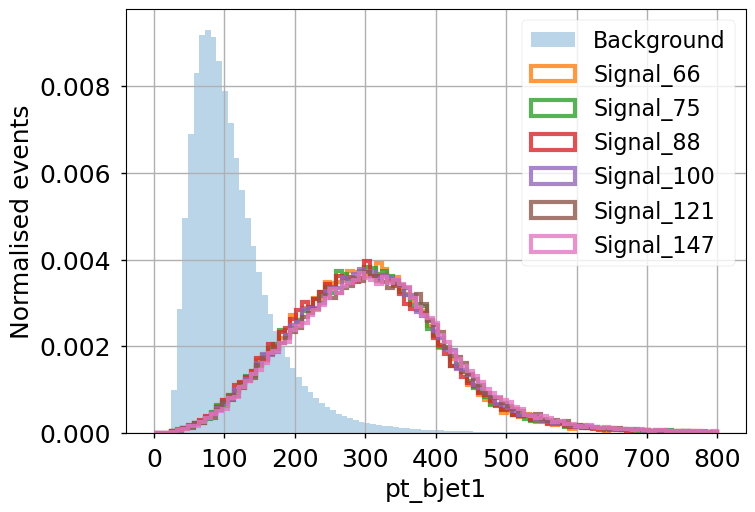

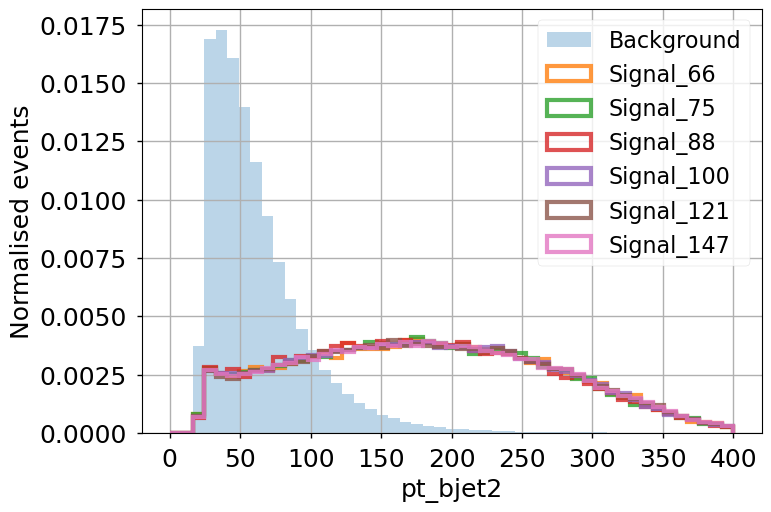

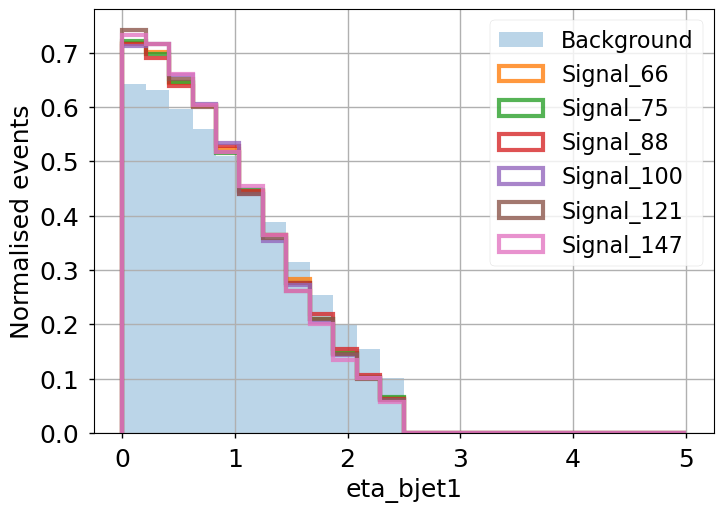

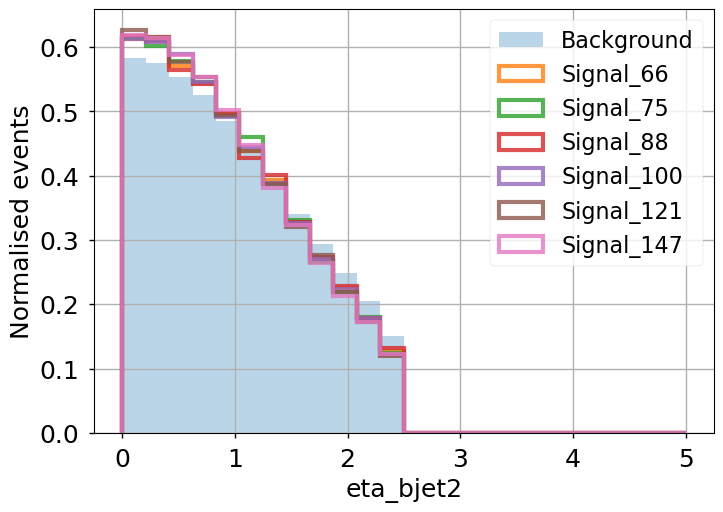

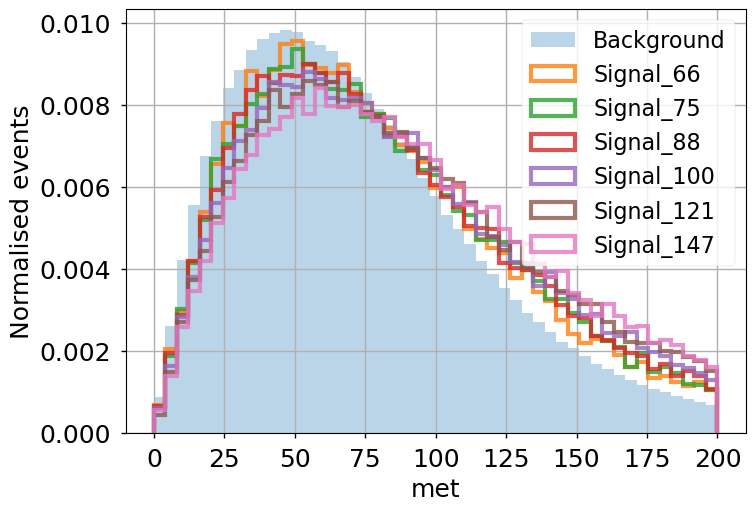

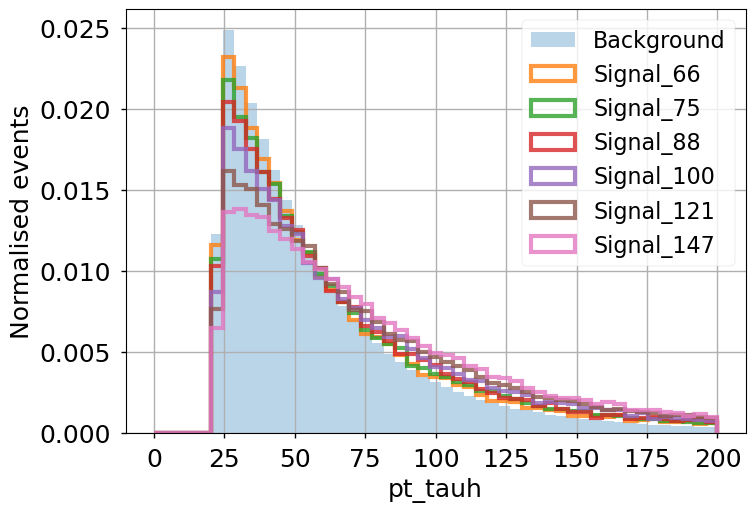

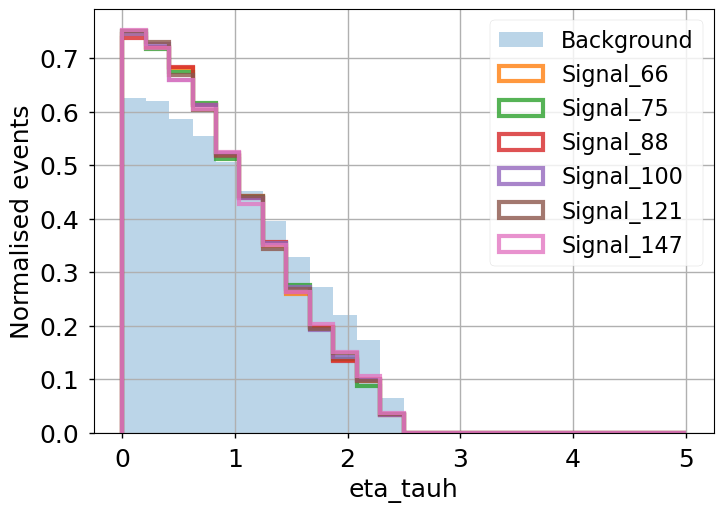

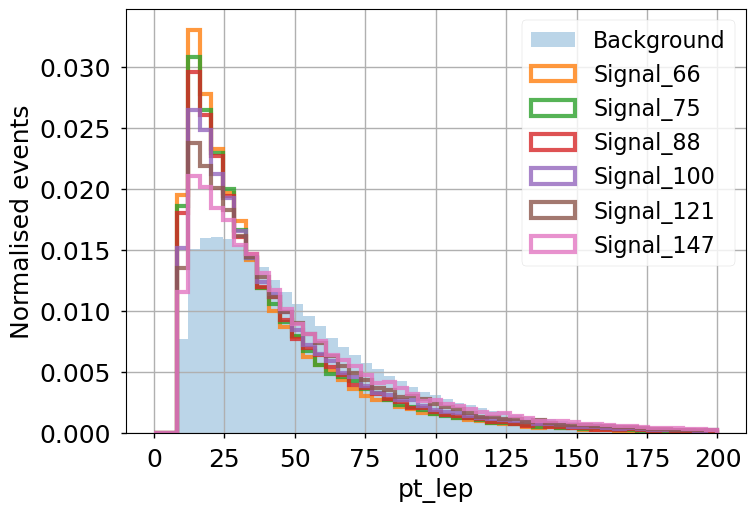

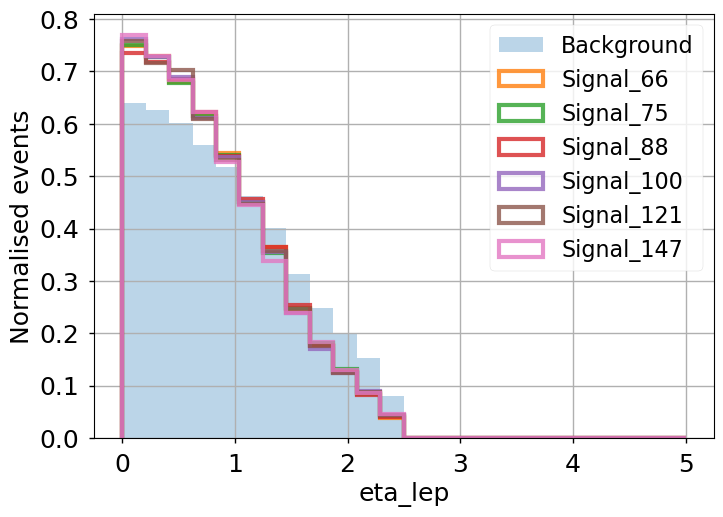

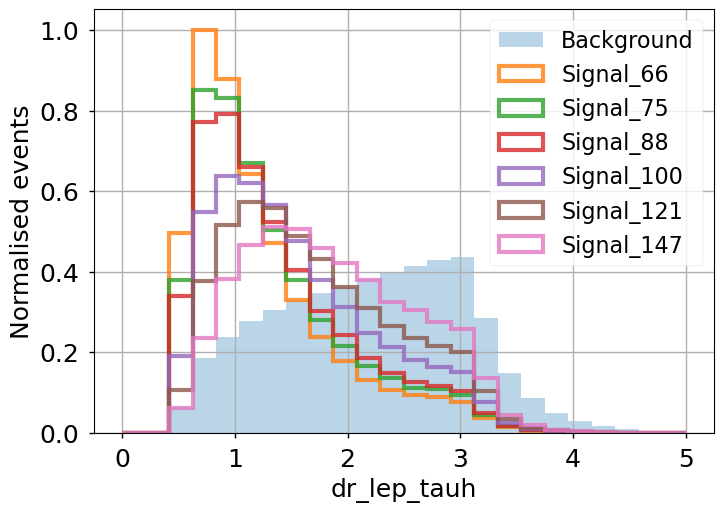

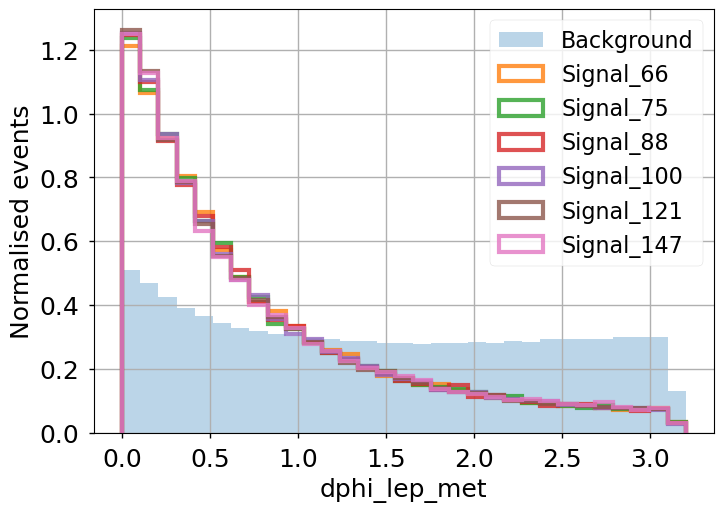

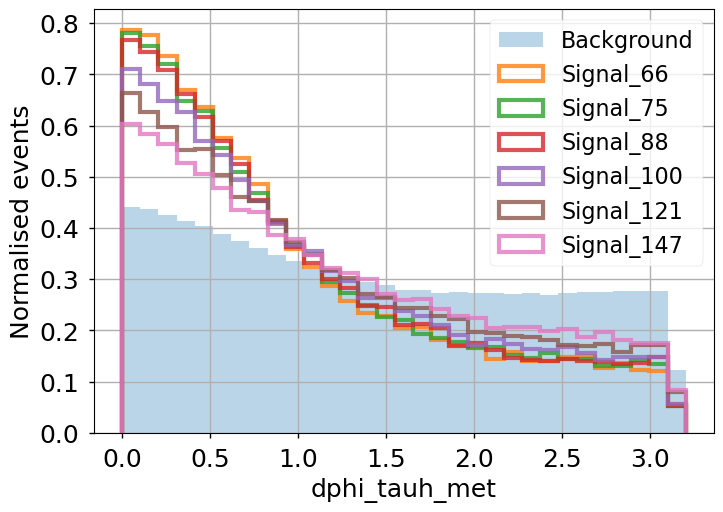

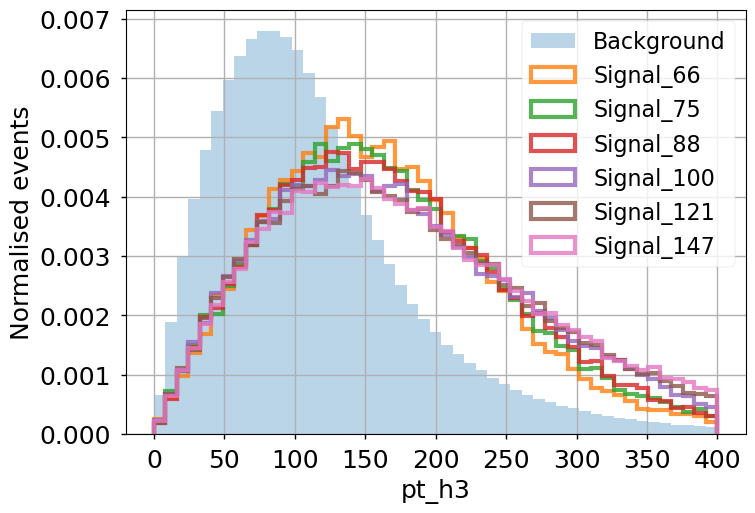

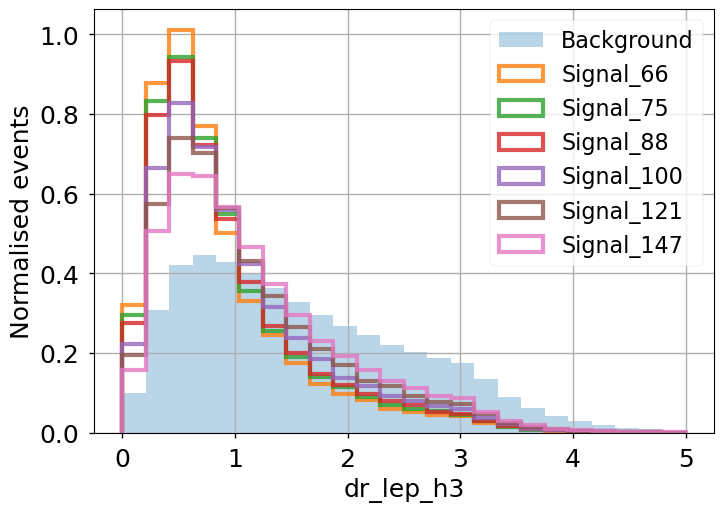

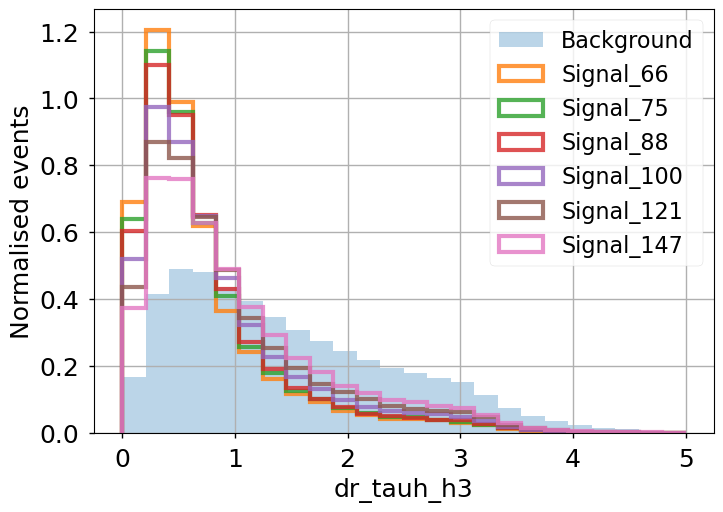

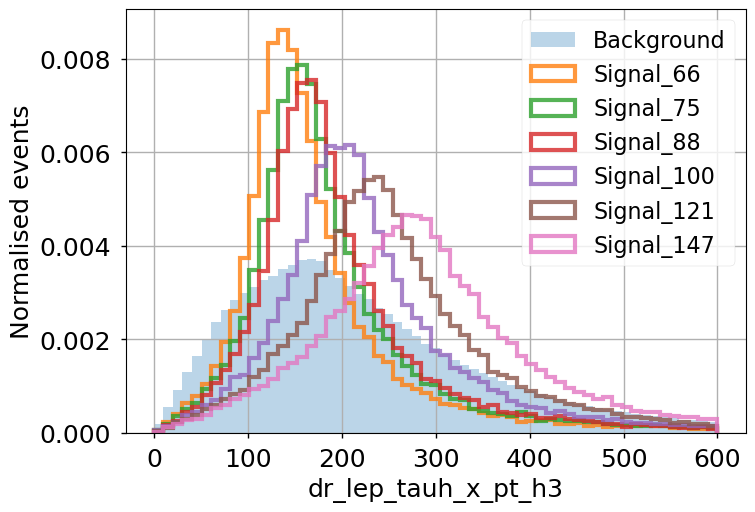

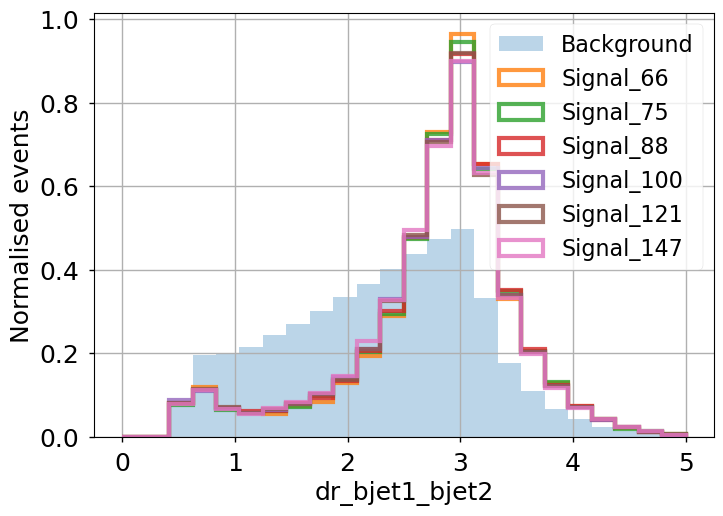

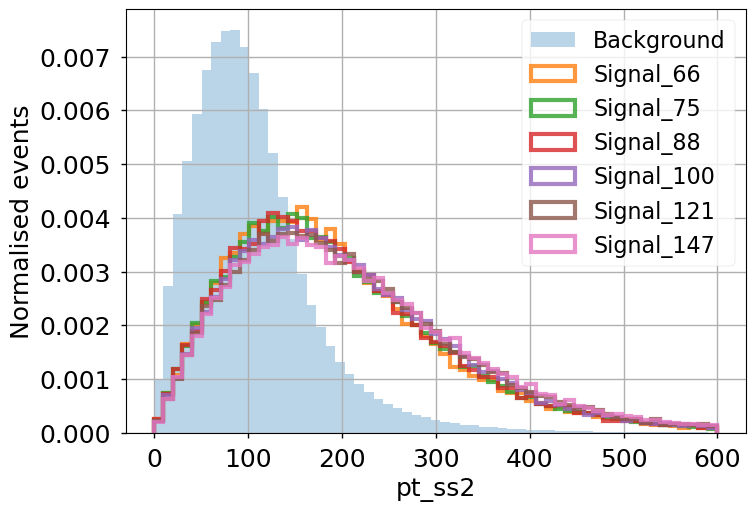

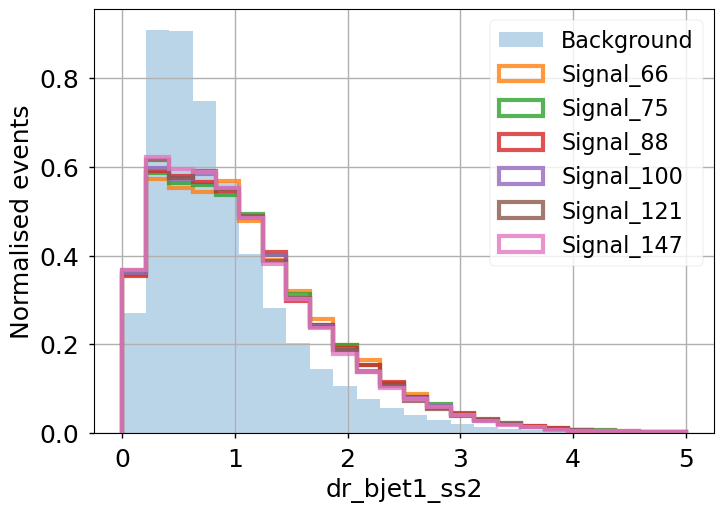

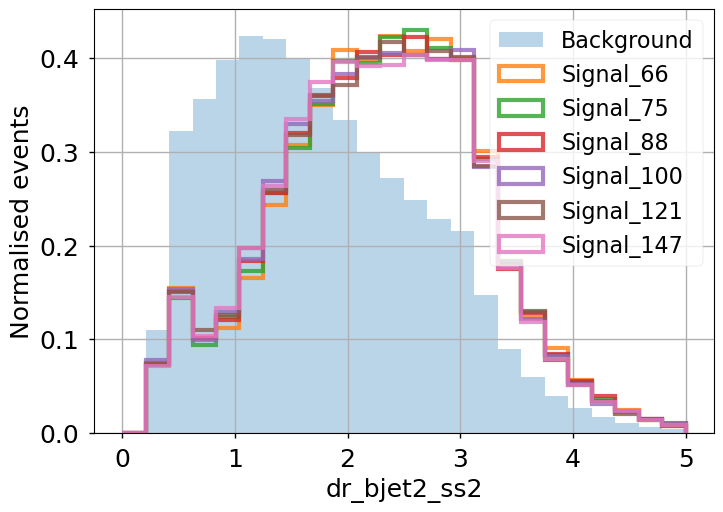

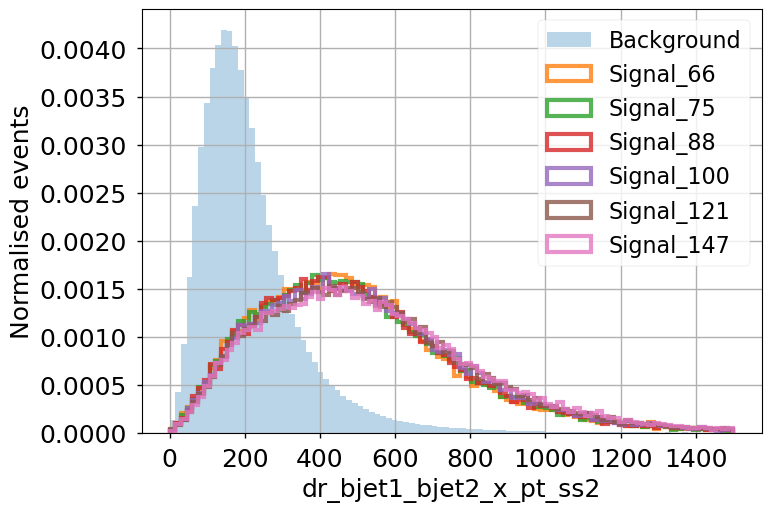

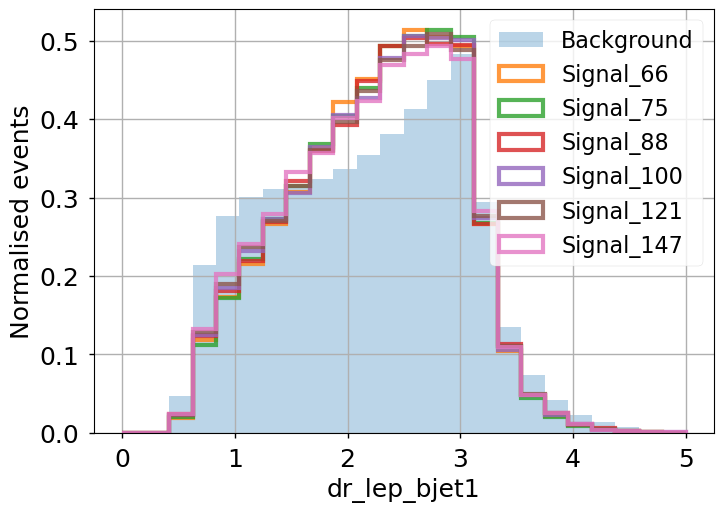

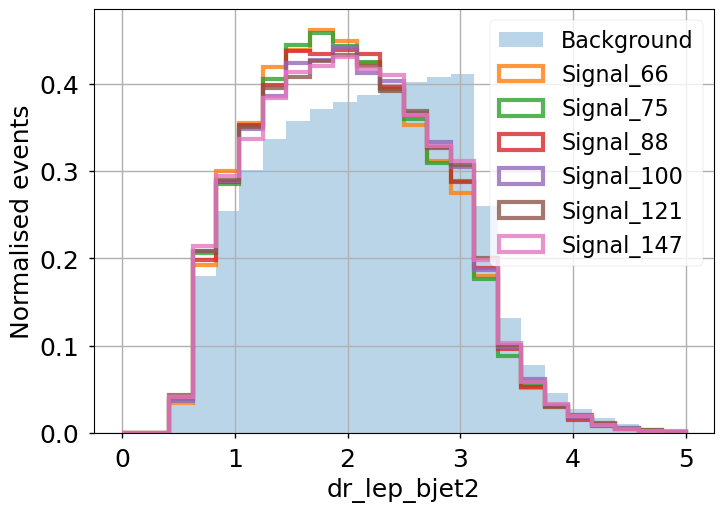

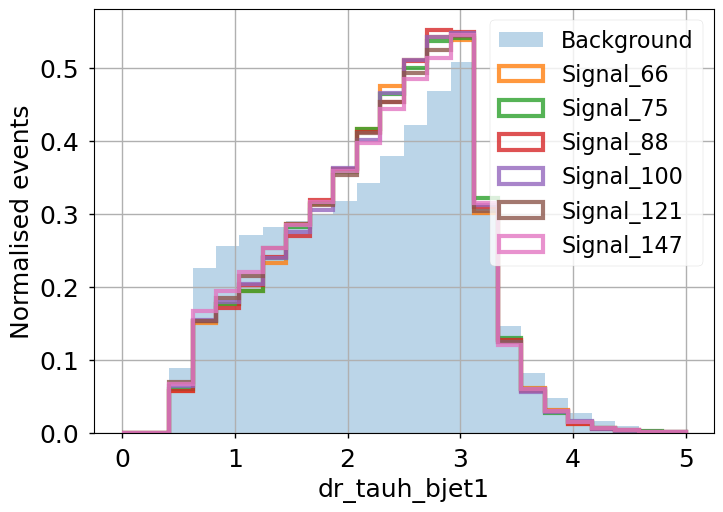

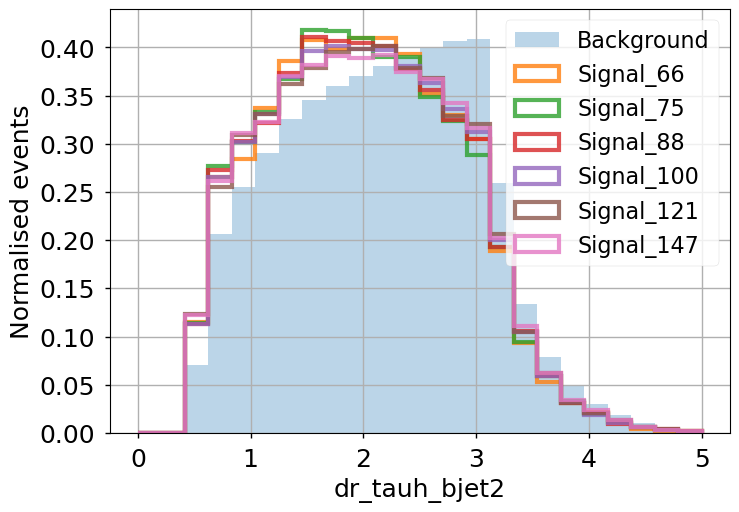

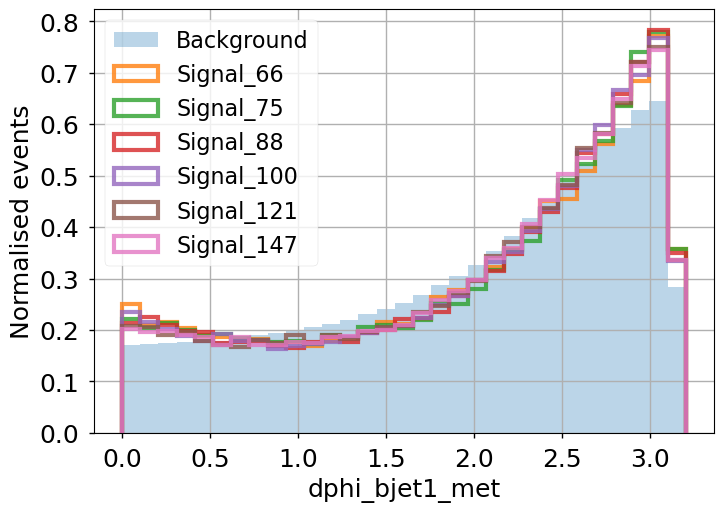

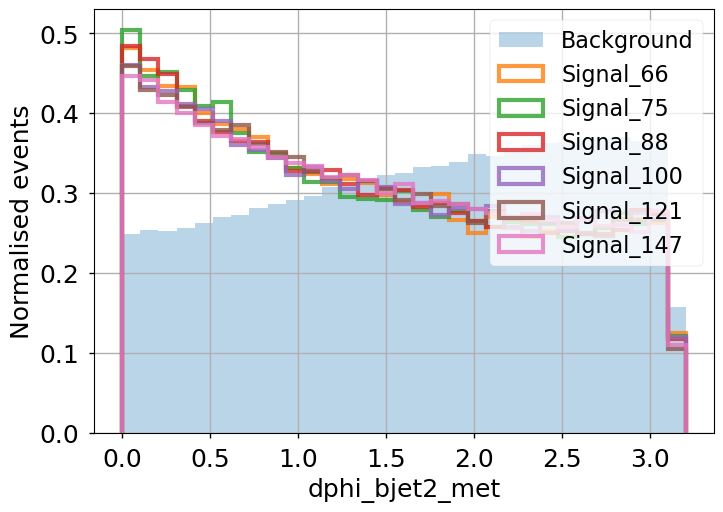

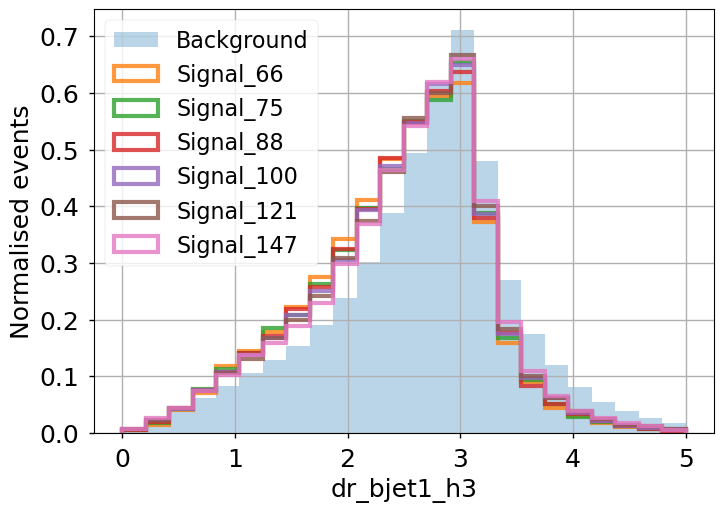

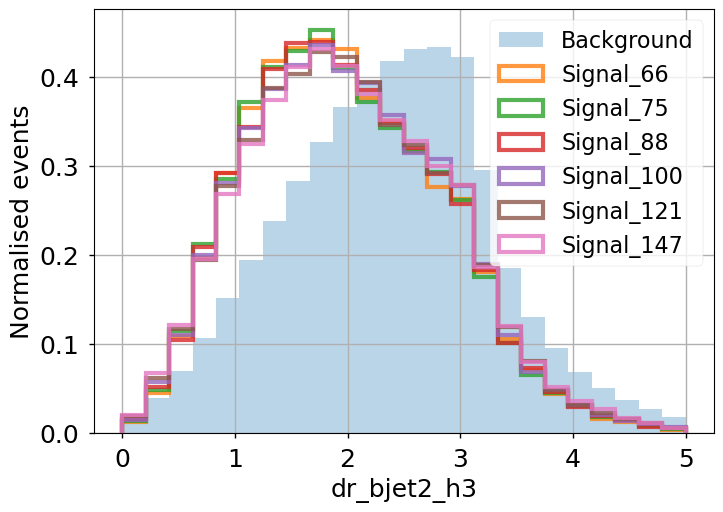

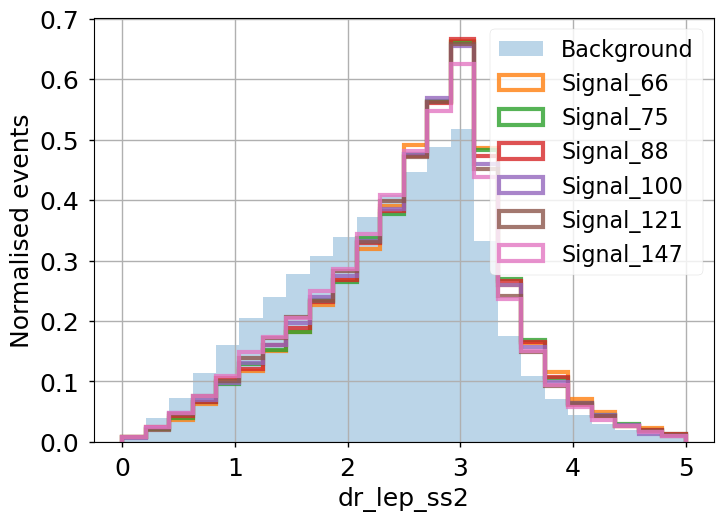

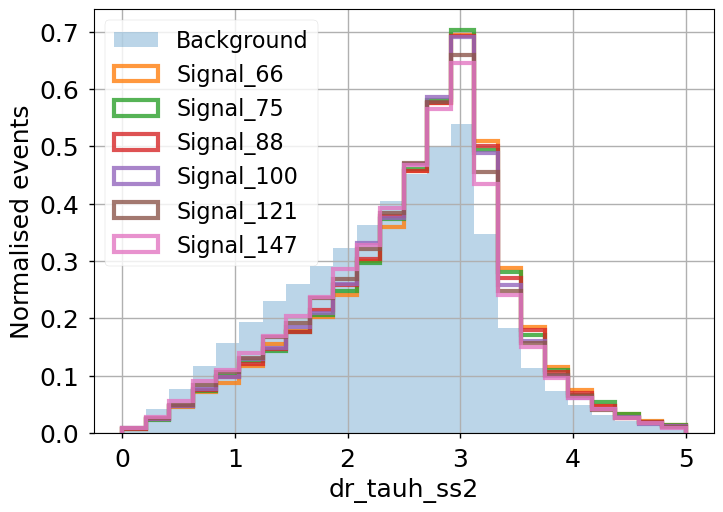

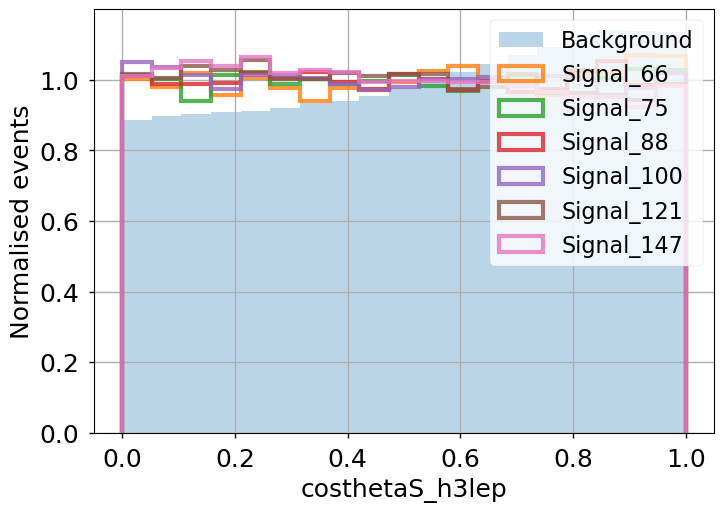

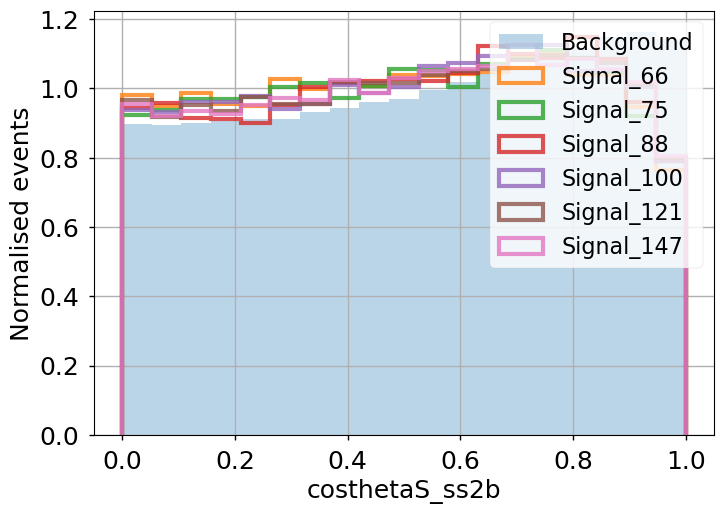

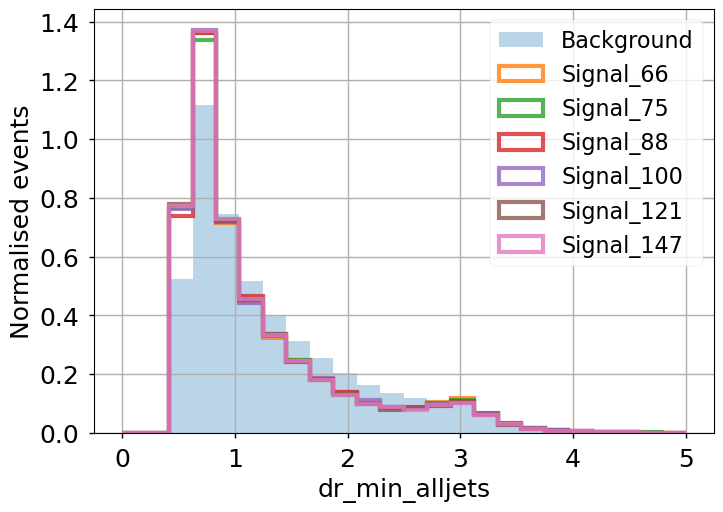

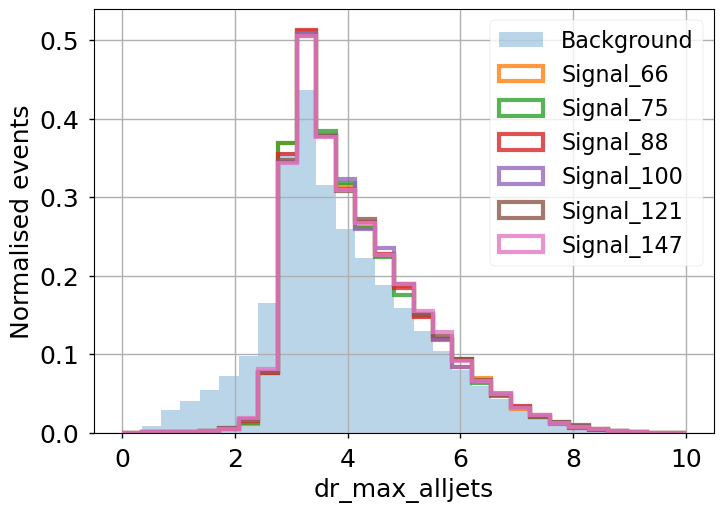

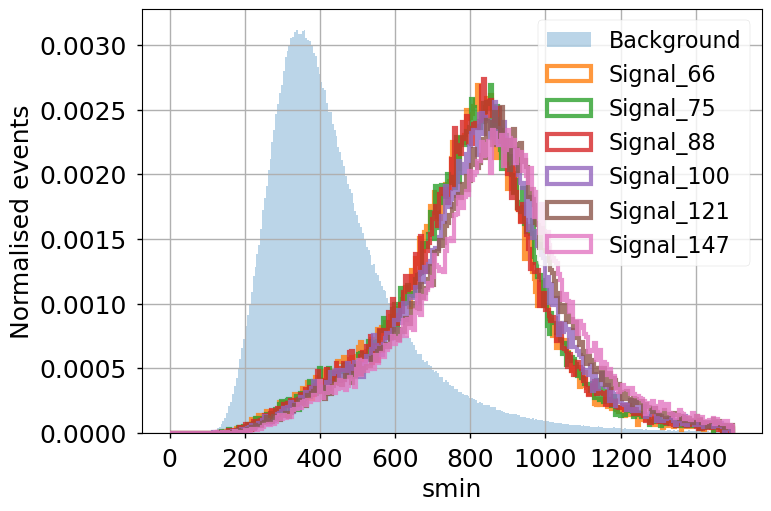

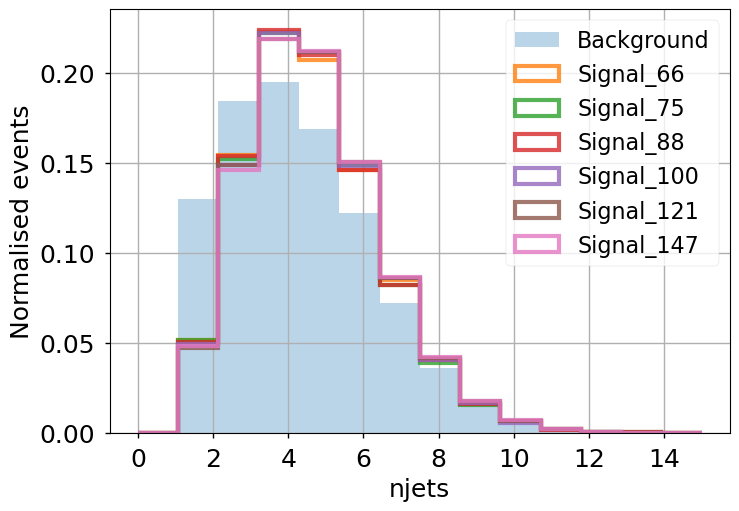

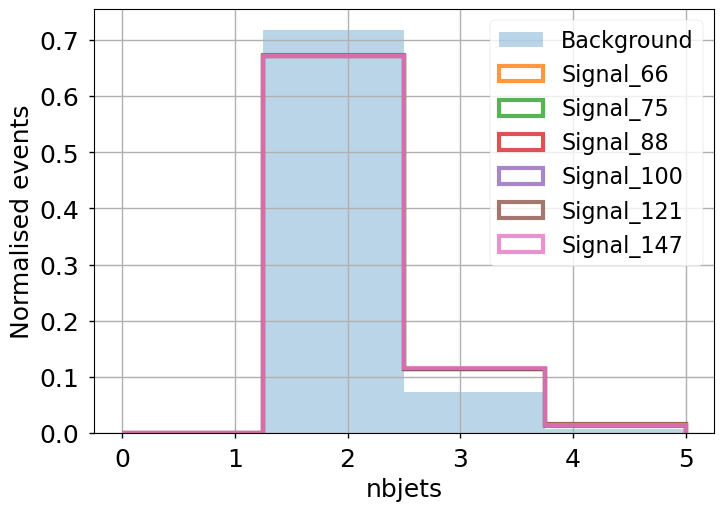

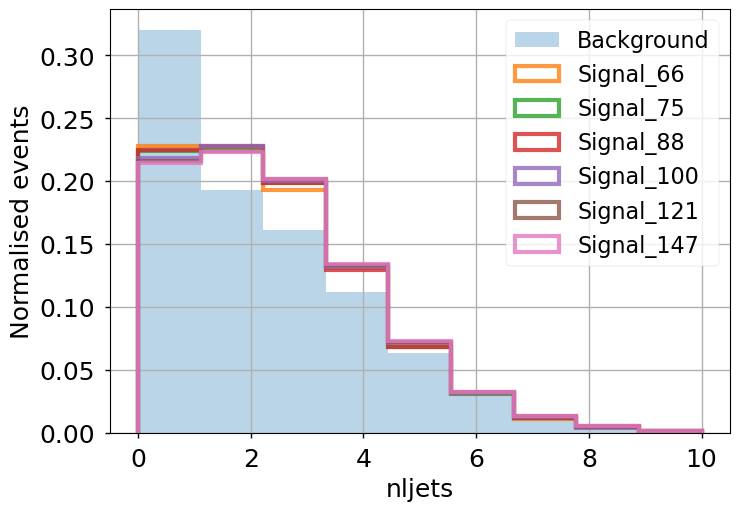

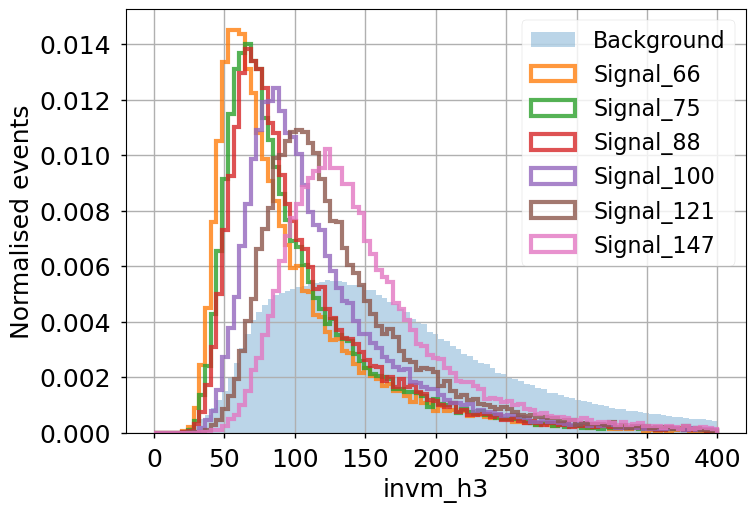

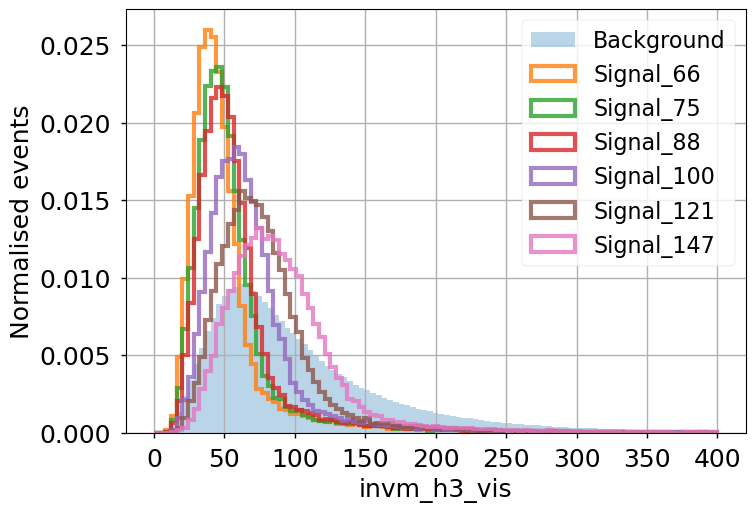

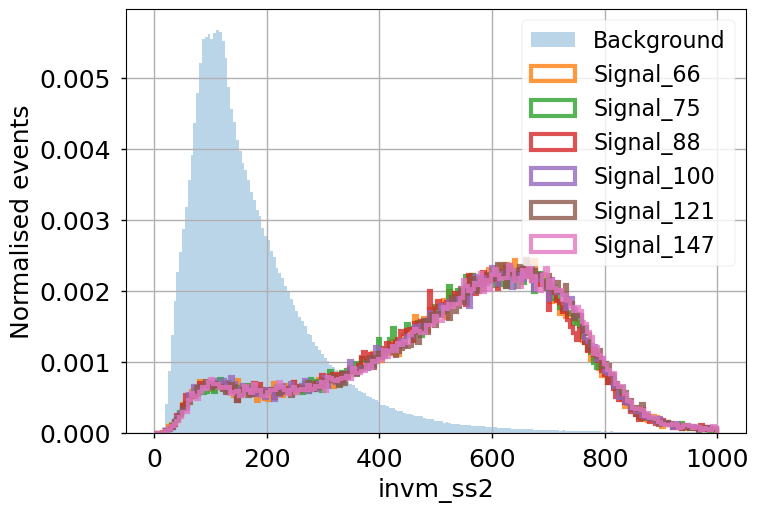

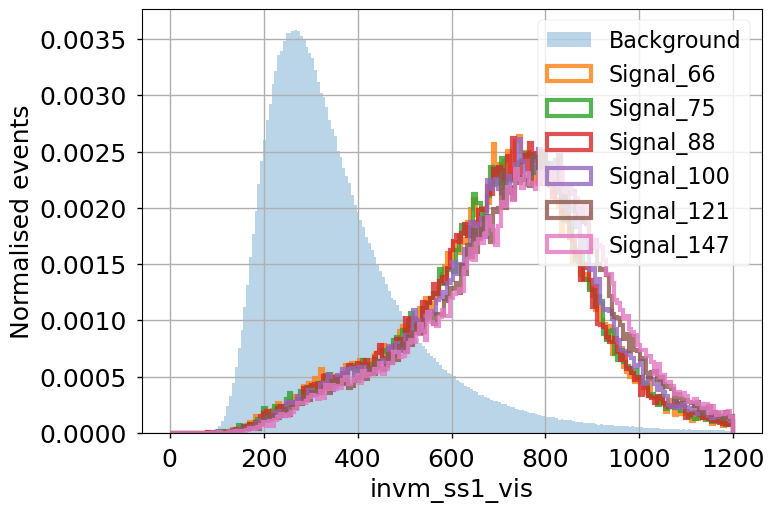

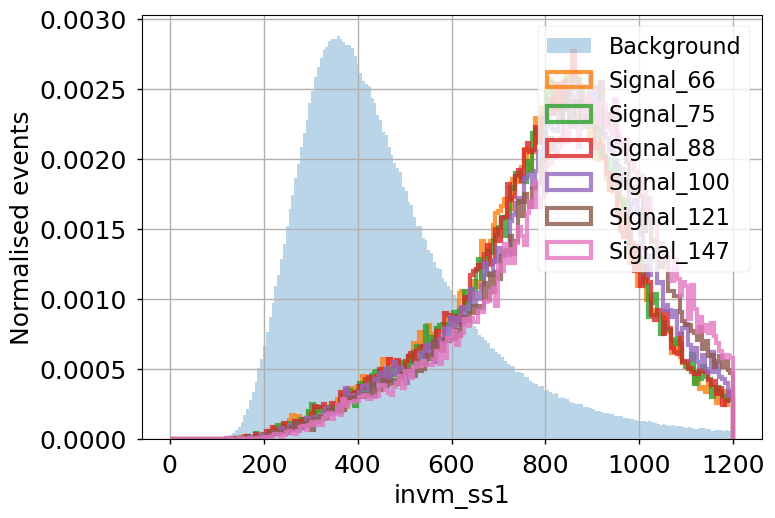

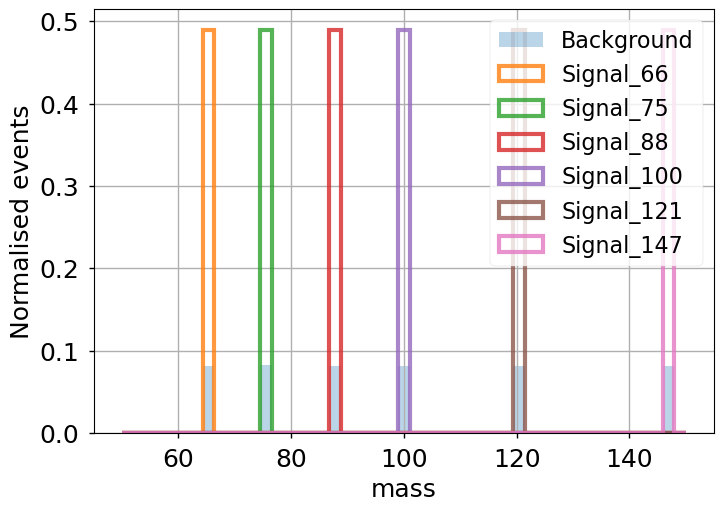

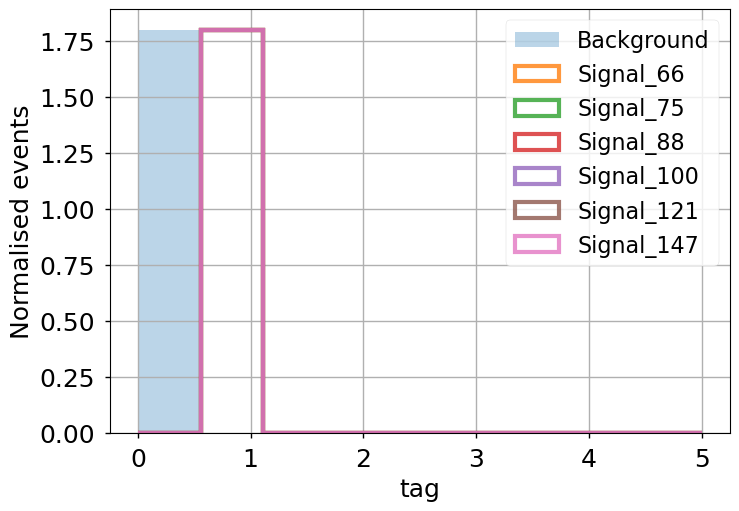

<Figure size 800x550 with 0 Axes>

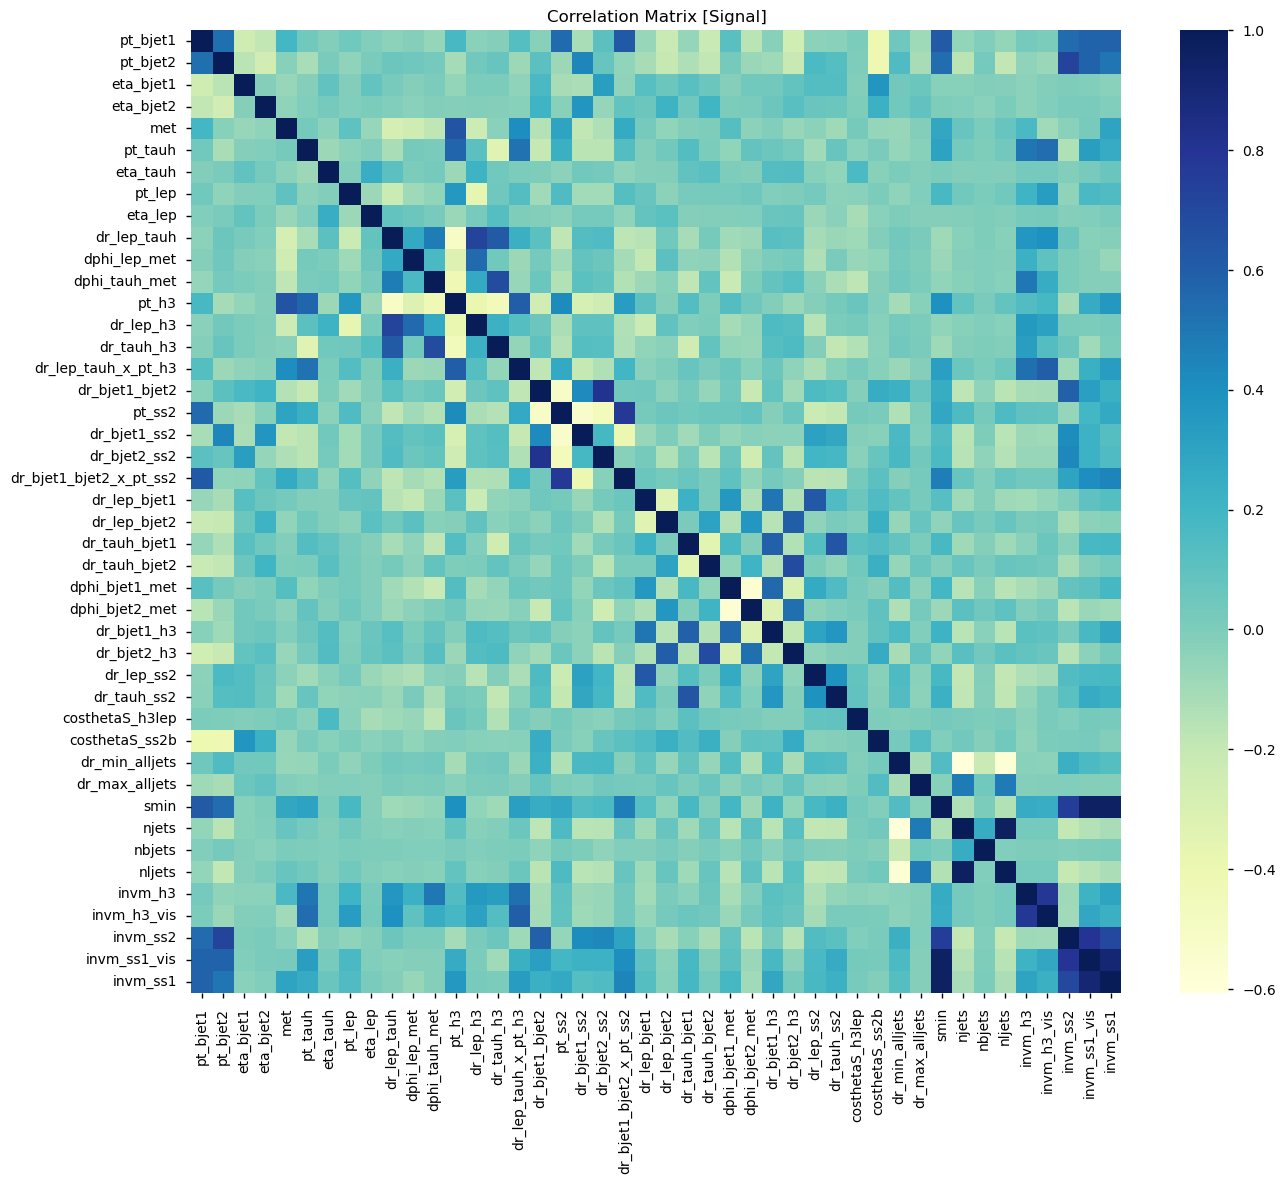

<Figure size 800x550 with 0 Axes>

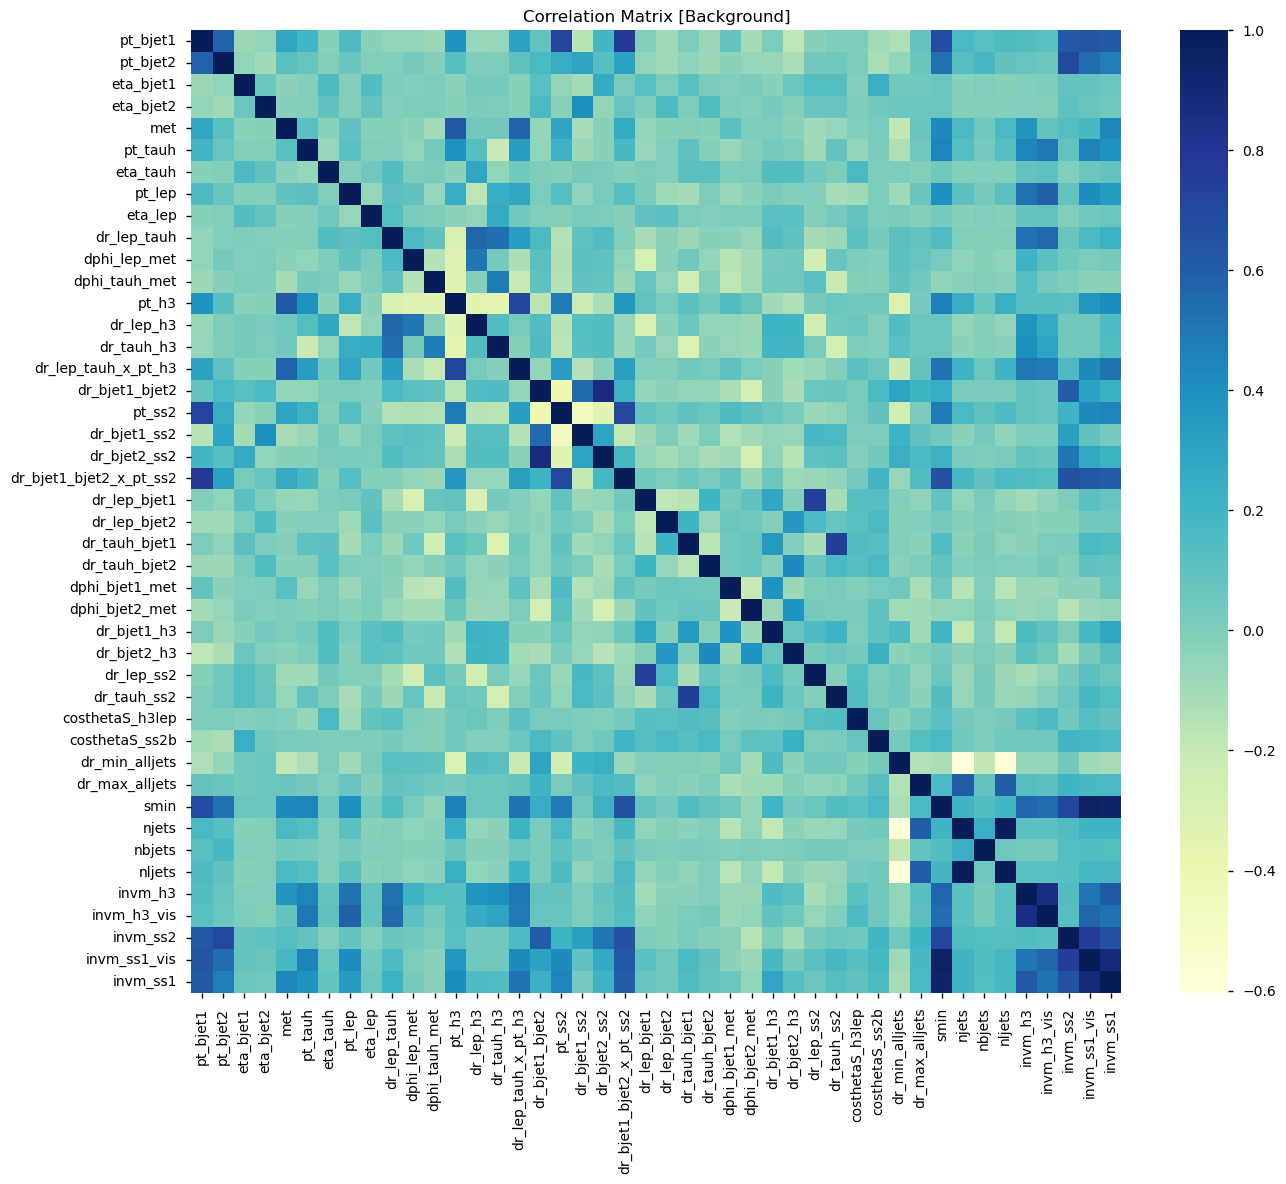


 Including all variables + spectators ...
df_total_sig: shape - (257006, 48), keys - Index(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh',
       'eta_tauh', 'pt_lep', 'eta_lep', 'dr_lep_tauh', 'dphi_lep_met',
       'dphi_tauh_met', 'pt_h3', 'dr_lep_h3', 'dr_tauh_h3',
       'dr_lep_tauh_x_pt_h3', 'dr_bjet1_bjet2', 'pt_ss2', 'dr_bjet1_ss2',
       'dr_bjet2_ss2', 'dr_bjet1_bjet2_x_pt_ss2', 'dr_lep_bjet1',
       'dr_lep_bjet2', 'dr_tauh_bjet1', 'dr_tauh_bjet2', 'dphi_bjet1_met',
       'dphi_bjet2_met', 'dr_bjet1_h3', 'dr_bjet2_h3', 'dr_lep_ss2',
       'dr_tauh_ss2', 'costhetaS_h3lep', 'costhetaS_ss2b', 'dr_min_alljets',
       'dr_max_alljets', 'smin', 'njets', 'nbjets', 'nljets', 'invm_h3',
       'invm_h3_vis', 'invm_ss2', 'invm_ss1_vis', 'invm_ss1', 'mass', 'tag',
       'wt', 'rel_weight'],
      dtype='object')
df_total_bkg: shape - (1344585, 48), keys - Index(['pt_bjet1', 'pt_bjet2', 'eta_bjet1', 'eta_bjet2', 'met', 'pt_tauh',
       'eta_tauh', 'pt_lep',

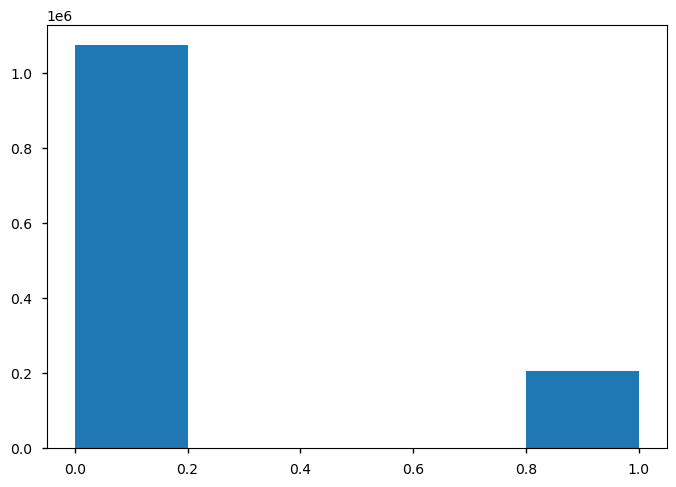

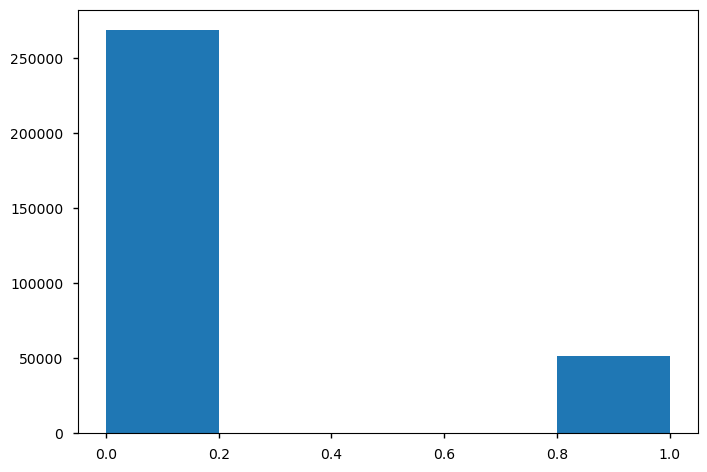


 np_train :
 [[6.29190483e+01 5.29032173e+01 2.03237033e+00 1.82653105e+00
  3.94819984e+01 4.55535507e+01 2.39058900e+00 3.32863998e+01
  1.36745703e+00 1.88732040e+00 4.16172147e-02 1.54431438e+00
  8.61245499e+01 1.27837396e+00 1.01271582e+00 1.62544617e+02
  2.29709864e+00 4.88119125e+01 1.22014952e+00 1.64406073e+00
  1.12125771e+02 1.18603635e+00 3.04797173e+00 7.02069283e-01
  1.77600491e+00 9.40509260e-01 3.05481863e+00 6.21941209e-01
  2.77475047e+00 2.40448046e+00 5.32909155e-01 6.10791028e-01
  1.80594534e-01 1.07209241e+00 3.61090755e+00 2.22915680e+02
  5.00000000e+00 2.00000000e+00 3.00000000e+00 6.60000000e+01
  0.00000000e+00]
 [9.93917847e+01 6.00106239e+01 3.98069084e-01 1.26738048e+00
  6.39714737e+01 1.01290703e+02 1.09500253e+00 2.23897266e+01
  1.40697944e+00 2.45548105e+00 3.22239995e-01 2.75782156e+00
  4.58515549e+01 1.87639785e+00 1.81320775e+00 1.12587624e+02
  2.88043618e+00 7.13862839e+01 1.30349815e+00 1.78955638e+00
  2.05623642e+02 2.09373355e+00 1.2967

scaled mass: values -> [-1.23423011 -0.91013793 -0.44200479 -0.00988188  0.7463332   1.68259949]
x-y shapes: (1281272, 40), (320319, 40), (1281272, 2), (320319, 2)

After scaling : [[-0.78380245 -0.43362656  1.8179143   1.28559779 -0.73800782 -0.37431799
   2.40278395 -0.48736357  0.77713727 -0.24631079 -1.38028808  0.18349116
  -0.47593847 -0.24194424 -0.37718682 -0.46082283 -0.09546343 -0.80915126
   0.47146211 -0.23102893 -0.72651121 -1.22574264  1.10179595 -1.79549226
  -0.42828084 -1.17758189  1.56672933 -2.39963927  0.47025699  0.0241775
  -2.11629136  0.31046974 -1.18489565 -0.28655278 -0.2348806  -1.14506058
   0.24295353 -0.33642702  0.31992441 -1.23423011]
 [-0.43510199 -0.32733732 -0.81494123  0.43254885 -0.30745151  0.66817177
   0.30118084 -0.73728829  0.84191632  0.41954216 -1.08531586  1.49351841
  -0.93532161  0.36331539  0.44126713 -0.7587993   0.57995924 -0.55941952
   0.59732351 -0.0750125  -0.29014302 -0.12158709 -1.04401223  1.1092837
  -1.16068853 -1.40452405 -0.0

In [4]:
# Load config
### open config.yaml and get all the necessary parameters
with open(os.path.join('Yamls', f'config_{channel}.yaml'), 'r') as inf:
    config = yaml.safe_load(inf)
    
mainkeys    = list(config.keys())
tag         = config.get('Tag')
tagdir      = os.path.join(os.getcwd(),tag)

if not os.path.exists(tagdir):
    os.mkdir(tagdir)
else:
    print(f'{tagdir} already exists ...\n')

maindir           = config.get('Basepath')
maintree          = config.get('Intree')
infiledict        = config.get('Infiles')
all_featuredict   = config.get('Features')
train_featuredict = all_featuredict.get('Variables')
print(f'Train_FeatureDict: {train_featuredict.keys()}\n')
spect_featuredict = all_featuredict.get('Spectators')
print(f'Spectator_FeatureDict: {spect_featuredict.keys()}\n')
featuredict       = {**train_featuredict, **spect_featuredict}
print(f'FeatureDict: {featuredict.keys()}\n')
featurelist       = list(featuredict.keys())
#print(f'all feature list : {featurelist}')
signaldict        = infiledict.get('Signal')
backgrounddict    = infiledict.get('Background')
masspoints        = config.get('Mass')
scale             = config.get('DoScaling')
#dotrain        = config.get('DoTrain')

modelparamdict = config.get('ModelParams')
LayerDims      = modelparamdict.get('Layers')
IsBatchNorm    = modelparamdict.get('BatchNorms')
DropOuts       = modelparamdict.get('Dropout')
L2regs         = modelparamdict.get('L2')
Activations    = modelparamdict.get('activ')

trainingparamdict = config.get('TrainingParams')
LossFunc = trainingparamdict.get('Loss')
LRate    = trainingparamdict.get('LR')
#print(f'Learning rate : {LRate}')
Metrics  = trainingparamdict.get('Metrics')
valSplit = trainingparamdict.get('valSplit')
nEpoch   = trainingparamdict.get('epoch') 
opt      = tensorflow.keras.optimizers.Adam(learning_rate=LRate)
batchsize = trainingparamdict.get('BatchSize')
#print(f'Batch size : {batchsize}')

# Prepare train-test datasets (panda df)
### Use root_panda to get the event info from root files

##################################################################
##################################################################
#signal_info_list     = list(signaldict.values())
#background_info_list = list(backgrounddict.values())

#print(signal_info_list)
#print(background_info_list)

dfs_signal     = []
dfs_background = []


print('\n preparing signal dataframes ...')
for k, (key, val) in enumerate(signaldict.items()):
    print(f'process: {key}')
    proc = key
    filepath = val[0]
    xsec     = val[1]
    mass     = masspoints[k]
    dfitem = prepare_df(maindir, filepath, maintree, xsec, mass, masspoints, 1, featurelist)
    dfs_signal.append(dfitem)
    
print('\n preparing background dataframes ...')
for key, val in backgrounddict.items():
    print(f'process: {key}')
    proc = key
    filepath = val[0]
    xsec     = val[1]
    mass     = 999
    #mass     = random.choice(masspoints)
    dfitem = prepare_df(maindir, filepath, maintree, xsec, mass, masspoints, 0, featurelist)
    dfs_background.append(dfitem)

'''
for i,item in enumerate(signal_info_list):
    filename = item[0]
    xsec     = item[1]
    mass     = masspoints[i]
    clstag   = 1
    dfitem = prepare_df(maindir, filename, maintree, xsec, mass, masspoints, clstag, featurelist)
    dfs_signal.append(dfitem)

for item in background_info_list:
    filename = item[0]
    xsec     = item[1]
    mass     = random.choice(masspoints)
    clstag   = 0
    dfitem = prepare_df(maindir, filename, maintree, xsec, mass, masspoints, clstag, featurelist)
    dfs_background.append(dfitem)
'''
#print(f'No of signal processes : {len(dfs_signal)}, bkg processes : {len(dfs_background)}')

df_total_sig = pd.concat(dfs_signal)
df_total_sig['rel_weight'] = 1.0

totwt = 0.0
for df in dfs_background:
    #print(f'''backgroud : {df['wt']}  : shape : {df.shape[0]} \n\n''')
    totwt += df['wt'][0] * df.shape[0]

for df in dfs_background:
    df['rel_weight'] = df['wt'] * df.shape[0] / totwt
    
df_total_bkg = pd.concat(dfs_background)
#print(df_total_bkg['rel_weight'])


#print(f'Total bkg weight : {totwt}\n\n\n')

#print(f'df_Signal shape      : {df_total_sig.shape}')
##print(df_total_sig.head())
#print(f'df_Background shape  : {df_total_bkg.shape}')    
##print(df_total_bkg.head())    
    
if dofeatplot : 
    # add mass and tag to feature dict
    tempdict = featuredict.copy()
    tempdict['mass'] = [50, 50, 150]
    tempdict['tag']  = [10, 0, 5]
    #plotinputfeatures(featuredict, dfs_signal, df_total_bkg, masspoints, tag='_feat')    
    plotinputfeatures(tempdict, dfs_signal, df_total_bkg, masspoints, tag='_feat')    
    # Correlation matrices
    ### Both for signal and background
    ################### For Correlation matrix ######################
    df_sig = df_total_sig[featurelist + ['tag']].iloc[:,:-1]
    df_bkg = df_total_bkg[featurelist + ['tag']].iloc[:,:-1]
    corrlMatrix_sig = df_sig.corr()
    corrlMatrix_bkg = df_bkg.corr()

    plt.figure(figsize=(15,12.5))
    #sns.heatmap(corrlMatrix_sig, cmap='YlGnBu', annot=True, annot_kws={'size':13}, fmt='.2f')
    sns.heatmap(corrlMatrix_sig, cmap='YlGnBu', annot=False)
    plt.title('Correlation Matrix [Signal]')
    plt.savefig(os.path.join(tagdir,'Corr_matrix_signal.png'), dpi=300)
    plt.savefig(os.path.join(tagdir,'Corr_matrix_signal.pdf'), dpi=300)
    plt.show()
    plt.clf()
    plt.figure(figsize=(15,12.5))
    #sns.heatmap(corrlMatrix_bkg, cmap='YlGnBu', annot=True, annot_kws={'size':13}, fmt='.2f')
    sns.heatmap(corrlMatrix_bkg, cmap='YlGnBu', annot=False)
    plt.title('Correlation Matrix [Background]')
    plt.savefig(os.path.join(tagdir,'Corr_matrix_bkg.png'), dpi=300)
    #plt.savefig(os.path.join(tagdir,'Corr_matrix_bkg.pdf'), dpi=300)
    plt.show()
    plt.clf()
    #################################################################
#df_total_sig.abs()
#df_total_bkg.abs()
print('\n Including all variables + spectators ...')
print(f'df_total_sig: shape - {df_total_sig.shape}, keys - {df_total_sig.keys()}')
print(f'df_total_bkg: shape - {df_total_bkg.shape}, keys - {df_total_bkg.keys()}')

# Keep the variables only. Drop the spectators
df_total_sig2 = df_total_sig.drop(list(spect_featuredict.keys()), axis=1)
df_total_bkg2 = df_total_bkg.drop(list(spect_featuredict.keys()), axis=1)

print('\n After dropping spectator ...')
print(f'df_total_sig: shape - {df_total_sig2.shape}, keys - {df_total_sig2.keys()}')
print(f'df_total_bkg: shape - {df_total_bkg2.shape}, keys - {df_total_bkg2.keys()}')

sigtrain,  sigtest  = train_test_split(df_total_sig2,  test_size=0.2,   random_state=42, shuffle=True)
bkgtrain,  bkgtest  = train_test_split(df_total_bkg2,  test_size=0.2,   random_state=42, shuffle=True)

df_train = pd.concat([sigtrain,bkgtrain])
df_train.sample(frac=1)
df_test  = pd.concat([sigtest,bkgtest])
df_test.sample(frac=1)


neg, pos = np.bincount(df_train['tag'])
total = neg + pos
#print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))


##df_train = df_train[featurelist + ['tag']]
##df_test  = df_test[featurelist + ['tag']]

##print(f'df_TRAIN shape : {df_train.shape}')
##print(f'df_TEST shape  : {df_test.shape}')


# Keep the sample weights separate
train_weight = df_train [['rel_weight']].to_numpy()
test_weight  = df_test  [['rel_weight']].to_numpy()

df_train = df_train[list(train_featuredict.keys()) + ['mass'] + ['tag']]
df_test  = df_test [list(train_featuredict.keys()) + ['mass'] + ['tag']]

print('\n dataframes of train and test ...')
print(f'df_train: {df_train[:10]}, {df_train.shape}, {df_train.keys()}')
print(f'df_test:  {df_test[:10]}, {df_test.shape}, {df_test.keys()}')
plt.hist(df_train['tag'], bins=5)
plt.show()
plt.hist(df_test['tag'], bins=5)
plt.show()

#df_combined_all_events = pd.concat([df_train, df_test], axis=0)
#print(f'Combined dataframe: shape - {df_combined_all_events.shape}, keys - {df_combined_all_events.keys()}')

# Prepare train and test datasets
np_train = df_train.to_numpy()
np_test  = df_test.to_numpy()

# randon shuffle: again?
np.random.shuffle(np_train)
np.random.shuffle(np_test)

print(f'\n np_train :\n {np_train[:2,:]} : {np_train.shape}')
print(f'\n np_test  :\n {np_test[:2,:]} : {np_test.shape}')
x_train  = np_train[:,:np_train.shape[1]-1]
y_train_ = np_train[:,-1].reshape(-1,1)
y_train  = to_categorical(y_train_, 2)
print(f'\n x_train :\n {x_train[:5,:]} : {x_train.shape}')
print(f'\n y_train :\n {y_train[:5,:]} : {y_train.shape}')
x_test   = np_test[:,:np_test.shape[1]-1]
y_test_  = np_test[:,-1].reshape(-1,1)
y_test   = to_categorical(y_test_, 2)
print(f'\n x_test :\n {x_test[:5,:]} : {x_test.shape}')
print(f'\n y_test :\n {y_test[:5,:]} : {y_test.shape}')

#print(f'Train --> Sig : {np.sum(y_train > 0)}   Bkg : {np.sum(y_train < 1)}')
#print(f'Test  --> Sig : {np.sum(y_test > 0)}    Bkg : {np.sum(y_test < 1)}')

# Scalar
#print(f'Do Scaling of input features : {scale}')
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
#scaler  = preprocessing.RobustScaler()
#scaler  = preprocessing.MinMaxScaler()
print(f'\nBefore scaling : {x_train[:2,:]}')
#temp = x_train[:,-1].reshape(x_train.shape[0],1)
#print(x_train[:,:-1].shape, temp.shape)
#temp2 = np.concatenate((x_train[:,:-1], temp), axis=1)
#print(temp2.shape)
raw_mass, raw_mass_idxs = np.unique(x_train[:,-1], return_index=True)
print(f'raw mass: values -> {raw_mass}\t indices -> {raw_mass_idxs}')

if scale:
    x_train = scaler.fit_transform(x_train)
    x_test  = scaler.transform(x_test)
    #x_train_scaled = scaler.fit_transform(x_train[:,:-1])
    #x_train = np.concatenate((x_train_scaled, x_train[:,-1].reshape(x_train.shape[0],1)), axis=1)
    #x_test_scaled  = scaler.transform(x_test[:,:-1])

masspoints = np.take(x_train[:,-1], raw_mass_idxs)
print(f'scaled mass: values -> {masspoints}')
#scaled_mass = np.take(x_train[:,-1], return_index=True)
    
print(f'x-y shapes: {x_train.shape}, {x_test.shape}, {y_train.shape}, {y_test.shape}')
print(f'\nAfter scaling : {x_train[:2,:]}')
dump(scaler, open(os.path.join(tagdir,'scaler.pkl'), 'wb'))


#clsWt = class_weight.compute_class_weight('balanced', np.unique(np_train[:,-1]), np_train[:,-1])
#clsWt = dict(zip(np.unique(np_train[:,-1]),
#                 class_weight.compute_class_weight('balanced', np.unique(np_train[:,-1]), 
#                                                   np_train[:,-1])))
#print(clsWt)
initbias = np.log(pos/neg)


# combine all for evaluation
#train_set = np.concatenate((x_train, y_train_), axis=1)
#test_set  = np.concatenate((x_test, y_test_), axis=1)

#combined_set = np.concatenate((train_set, test_set), axis=0)
#print(combined_set, combined_set.shape)
print(f'Masspoints : {masspoints}')


{0: 0.595570380451961, 1: 1.5579366160191437}


2022-11-11 00:02:37.942762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 00:02:37.946587: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-11 00:02:37.947701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-11-11 00:02:37.947767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-11 00:02:37.947798: I tensorflow/stream_executor/platfor

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1028)         42148       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1028)         4112        dense[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 1028)         0           batch_normalization[0][0]        
______________________________________________________________________________________________

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


2022-11-11 00:02:39.801842: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-11 00:02:39.802445: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


Epoch 1/500


2022-11-11 00:02:44.865317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


206/206 [==============================] - 18s 61ms/step - loss: 1.9541 - categorical_accuracy: 0.8580 - auc: 0.8786 - precision: 0.8508 - recall: 0.8310 - val_loss: 0.4536 - val_categorical_accuracy: 0.9036 - val_auc: 0.9707 - val_precision: 0.9099 - val_recall: 0.8887
Epoch 2/500
206/206 [==============================] - 10s 50ms/step - loss: 0.3126 - categorical_accuracy: 0.9338 - auc: 0.9650 - precision: 0.9366 - recall: 0.9305 - val_loss: 0.3333 - val_categorical_accuracy: 0.8720 - val_auc: 0.9684 - val_precision: 0.8768 - val_recall: 0.8650
Epoch 3/500
206/206 [==============================] - 10s 49ms/step - loss: 0.2127 - categorical_accuracy: 0.9352 - auc: 0.9740 - precision: 0.9378 - recall: 0.9321 - val_loss: 0.3379 - val_categorical_accuracy: 0.8711 - val_auc: 0.9508 - val_precision: 0.8748 - val_recall: 0.8660
Epoch 4/500
206/206 [==============================] - 10s 48ms/step - loss: 0.2717 - categorical_accuracy: 0.9288 - auc: 0.9708 - precision: 0.9307 - recall: 0.92

Epoch 30/500
206/206 [==============================] - 10s 49ms/step - loss: 0.1504 - categorical_accuracy: 0.9401 - auc: 0.9858 - precision: 0.9411 - recall: 0.9391 - val_loss: 0.1457 - val_categorical_accuracy: 0.9500 - val_auc: 0.9900 - val_precision: 0.9499 - val_recall: 0.9502
Epoch 31/500
206/206 [==============================] - 10s 48ms/step - loss: 0.1328 - categorical_accuracy: 0.9484 - auc: 0.9889 - precision: 0.9486 - recall: 0.9483 - val_loss: 0.1396 - val_categorical_accuracy: 0.9520 - val_auc: 0.9910 - val_precision: 0.9525 - val_recall: 0.9515
Epoch 32/500
206/206 [==============================] - 10s 49ms/step - loss: 0.1242 - categorical_accuracy: 0.9497 - auc: 0.9896 - precision: 0.9499 - recall: 0.9496 - val_loss: 0.2174 - val_categorical_accuracy: 0.9182 - val_auc: 0.9787 - val_precision: 0.9182 - val_recall: 0.9182
Epoch 33/500
206/206 [==============================] - 10s 49ms/step - loss: 0.1328 - categorical_accuracy: 0.9473 - auc: 0.9885 - precision: 0.947

206/206 [==============================] - 10s 49ms/step - loss: 0.1165 - categorical_accuracy: 0.9518 - auc: 0.9904 - precision: 0.9517 - recall: 0.9520 - val_loss: 0.1208 - val_categorical_accuracy: 0.9588 - val_auc: 0.9931 - val_precision: 0.9587 - val_recall: 0.9589
Epoch 59/500
206/206 [==============================] - 10s 49ms/step - loss: 0.1151 - categorical_accuracy: 0.9519 - auc: 0.9905 - precision: 0.9521 - recall: 0.9517 - val_loss: 0.1211 - val_categorical_accuracy: 0.9551 - val_auc: 0.9921 - val_precision: 0.9554 - val_recall: 0.9549
Epoch 60/500
206/206 [==============================] - 10s 49ms/step - loss: 0.1149 - categorical_accuracy: 0.9510 - auc: 0.9903 - precision: 0.9511 - recall: 0.9509 - val_loss: 0.1203 - val_categorical_accuracy: 0.9553 - val_auc: 0.9922 - val_precision: 0.9549 - val_recall: 0.9557
Epoch 61/500
206/206 [==============================] - 10s 49ms/step - loss: 0.1134 - categorical_accuracy: 0.9516 - auc: 0.9907 - precision: 0.9516 - recall: 0

Epoch 87/500
206/206 [==============================] - 10s 50ms/step - loss: 0.1135 - categorical_accuracy: 0.9516 - auc: 0.9905 - precision: 0.9521 - recall: 0.9511 - val_loss: 0.1240 - val_categorical_accuracy: 0.9536 - val_auc: 0.9913 - val_precision: 0.9538 - val_recall: 0.9533
Epoch 88/500
206/206 [==============================] - 10s 49ms/step - loss: 0.1141 - categorical_accuracy: 0.9502 - auc: 0.9900 - precision: 0.9503 - recall: 0.9501 - val_loss: 0.1117 - val_categorical_accuracy: 0.9596 - val_auc: 0.9931 - val_precision: 0.9595 - val_recall: 0.9597
Epoch 89/500
206/206 [==============================] - 10s 50ms/step - loss: 0.1112 - categorical_accuracy: 0.9521 - auc: 0.9909 - precision: 0.9526 - recall: 0.9515 - val_loss: 0.1152 - val_categorical_accuracy: 0.9570 - val_auc: 0.9927 - val_precision: 0.9569 - val_recall: 0.9571
Epoch 90/500
206/206 [==============================] - 10s 49ms/step - loss: 0.1105 - categorical_accuracy: 0.9522 - auc: 0.9908 - precision: 0.952

Curves saved as Loss_Acc_LR.png
dict_keys(['loss', 'categorical_accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_categorical_accuracy', 'val_auc', 'val_precision', 'val_recall', 'lr'])


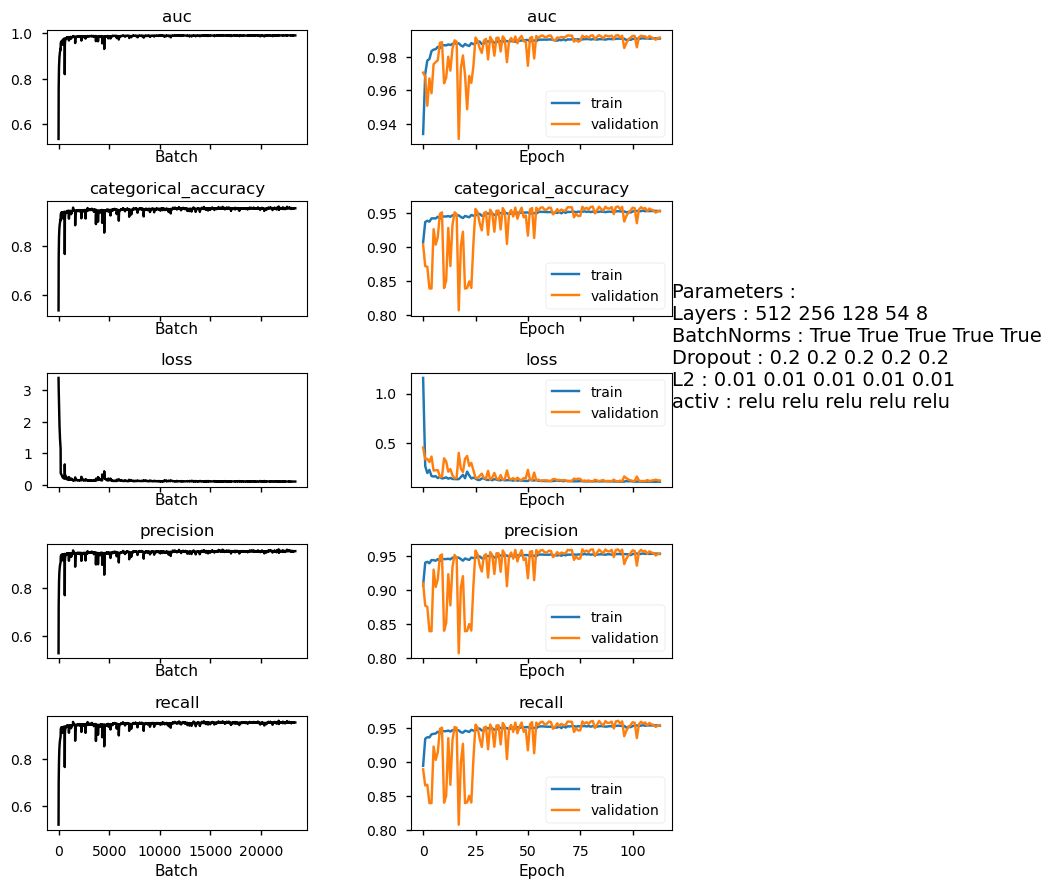

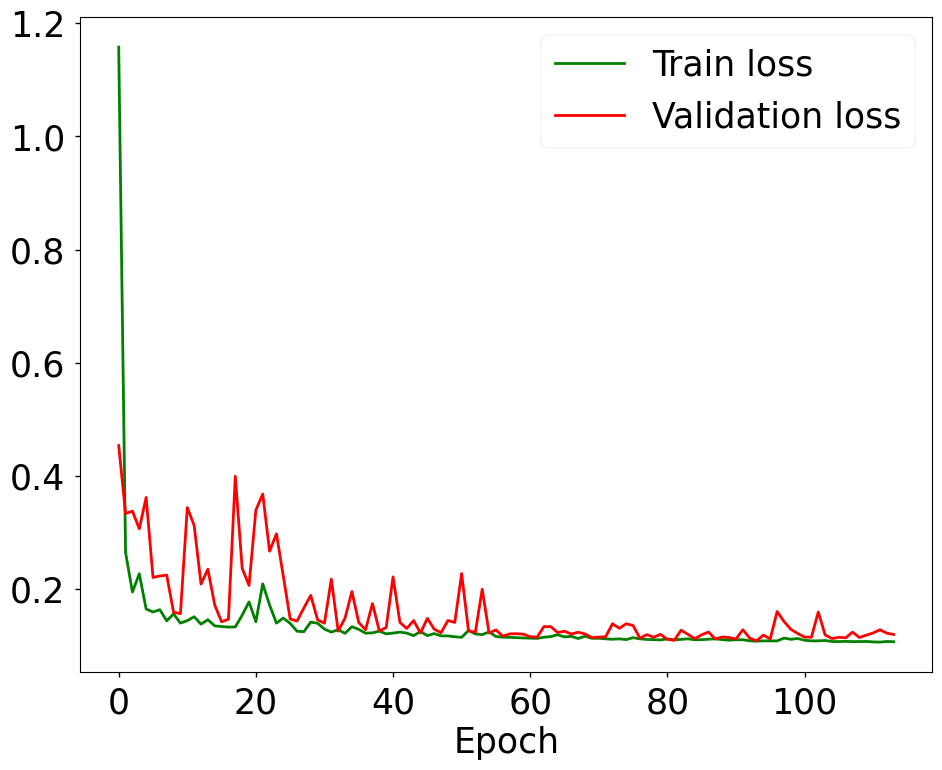

<Figure size 800x550 with 0 Axes>

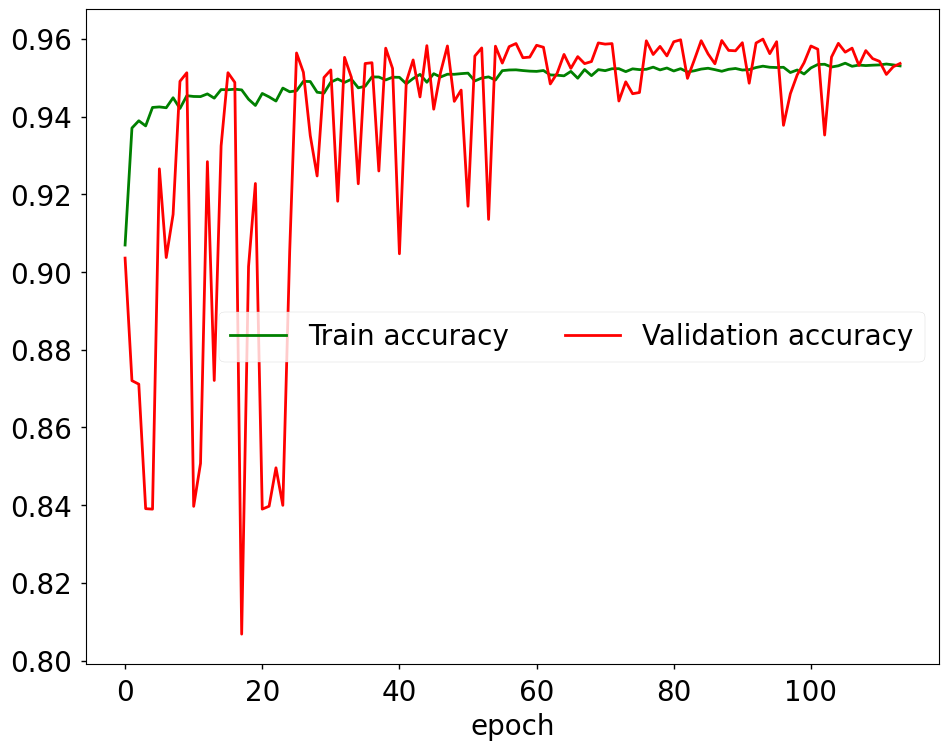

Saved model to disk


'    \nelse:\n    json_file  = open(os.path.join(tagdir,"DNN_model.json"), \'r\')\n    model_json = json_file.read()\n    json_file.close()\n    model = model_from_json(model_json)\n    # load weights into new model                                                                                                                             \n    model.load_weights(os.path.join(tagdir,"DNN_model.h5"))\n    print("Loaded model from disk")\n\n    print(model)\n'

<Figure size 800x550 with 0 Axes>

In [5]:
#https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
#######################################################################
#clsWt = {0:0.5*sigtrain.shape[0]/(sigtrain.shape[0]+bkgtrain.shape[0]), 
#         1:0.5*bkgtrain.shape[0]/(sigtrain.shape[0]+bkgtrain.shape[0])}
#print(clsWt)
#sigclswt = sigtrain.shape[0]/bkgtrain.shape[0] if sigtrain.shape[0] < bkgtrain.shape[0] else bkgtrain.shape[0]/sigtrain.shape[0]
#bkgclswt = 1/sigclswt
#clsWt    = {0 : sigclswt, 1 : 0.1*bkgclswt}
# ----------------------------------------------- #
# low signal weight shows better result
# need to find ref
# ----------------------------------------------- #
fac = 0.5
wt0 = (1/neg)*(total/2.0)
wt1 = (1/pos)*(total/2.0)
clsWt = {0: wt0, 1: fac*wt1}
print(clsWt)
#######################################################################
if dotrain:
    '''    
    # Build model 
    ### Binary-classification
    model = Sequential()
    for i in range(len(LayerDims)):
        if i == 0:
            model.add(Dense(LayerDims[i], 
                        input_dim=df_train.shape[1]-1,
                        #activation=Activations[i],
                        #activation=LeakyReLU(),
                        kernel_regularizer=regularizers.l2(L2regs[i])))
            model.add(LeakyReLU())
        else:
            
            model.add(Dense(LayerDims[i],
                            #activation=Activations[i],
                            #activation=LeakyReLU(),
                            kernel_regularizer=regularizers.l2(L2regs[i])))
            model.add(LeakyReLU())
            #model.add(kernel_regularizer=regularizers.l2(L2regs[i]))
        model.add(BatchNormalization()) if IsBatchNorm[i] else None
        model.add(Dropout(DropOuts[i]))
    

    #model.add(Dense(2, activation='softmax'))
    model.add(Dense(2, activation='sigmoid'))
    #model.add(Dense(2, activation='sigmoid'))
    model.summary()
    '''
    model = build_model(df_train.shape[1]-1, 2)
    model.summary()
    
    # Compile and fit
    #set early stopping monitor so the model stops training when it won't improve anymore                                                                     
    #early_stopping_monitor = EarlyStopping(patience=3)                                                                                                       
    # https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd                                              
    custom_early_stopping = EarlyStopping(
        monitor='val_loss',
        #monitor='loss',
        #patience=int(nEpoch/10),
        patience=20,                                                                                                                                         
        min_delta=0.0001,
        verbose=1,
        restore_best_weights=True,
        #restore_best_weights=False,                                                                                                                          
        mode='min'
        #mode='max'                                                                                                                                           
    )
    #https://keras.io/api/callbacks/reduce_lr_on_plateau/                                                                                                     
    custom_ReduceLROnPlateau = ReduceLROnPlateau(
        monitor="val_loss",
        #monitor="loss",                                                                                                                  
        factor=0.5, #0.1
        #patience=5,                                                                                                                                          
        patience=10,
        verbose=1,
        mode="min",
        #mode="max",                                                                                                                                          
        cooldown=0,                                                                                                                                          
        #cooldown=5,
        #min_lr=0
        min_lr=1e-7,                                                                                                                                         
        min_delta=0.0001                                                                                                                                      
    )
    '''
    #model checkpoint
    #https://keras.io/api/callbacks/model_checkpoint/
    custom_ModelChkp = ModelCheckpoint(
        filepath,
        monitor="val_loss",
        verbose=0,
        save_best_only=False,
        save_weights_only=False,
        mode="auto",
        save_freq="epoch",
        options=None,
        initial_value_threshold=None,
        **kwargs
    )
    '''
    #custom loss-history with batch
    #https://github.com/cp3-llbb/HHbbWWAnalysis/blob/master/MachineLearning/HHMachineLearning/Model.py#L47
    class LossHistory(Callback):
        """ Records the history of the training per epoch and per batch """
        def on_train_begin(self, logs={}):
            self.epochs  = defaultdict(list) 
            self.batches = defaultdict(list) 
            self.pre_batch = 0

        def on_batch_end(self, batch, logs={}):
            self.batches['batch'].append(batch+self.pre_batch)
            for key,val in logs.items():
                self.batches[key].append(val)
            self.batches['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
            #loss = logs.get('loss')
            #print(f'\nBatch : {batch} with average loss : {loss}')

        def on_epoch_end(self, epoch, logs={}):
            self.epochs['epoch'].append(epoch)
            for key,val in logs.items():
                self.epochs[key].append(val)
            self.epochs['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
            self.pre_batch = self.batches['batch'][-1] 

    loss_history = LossHistory()
    model.compile(loss=LossFunc, 
                  optimizer=opt, 
                  metrics=[tensorflow.keras.metrics.CategoricalAccuracy(),
                           tensorflow.keras.metrics.AUC(),
                           tensorflow.keras.metrics.Precision(),
                           tensorflow.keras.metrics.Recall()])
    plot_model(model, to_file=os.path.join(tagdir,'modelDNN.png'),show_shapes=True,show_layer_names=True)
    callback_list = [custom_early_stopping, custom_ReduceLROnPlateau, loss_history]
    #callback_list = [custom_ReduceLROnPlateau, loss_history]
    history = model.fit(x_train, y_train, 
                        #sample_weight=train_weight,
                        epochs=nEpoch, 
                        batch_size=batchsize, 
                        validation_split=valSplit,
                        verbose=1, 
                        #class_weight=None, 
                        class_weight=clsWt, 
                        use_multiprocessing=True,
                        callbacks=callback_list)
    
    
    
    # PLot History
    PlotHistory(loss_history, modelparamdict)
    # Loss and accuracy
    trainKeys = [key for key in history.history.keys() if not 'val' in key]
    valKeys   = [key for key in history.history.keys() if 'val' in key]
    #plt.style.use('seaborn')
    print(history.history.keys())
    plt.figure(figsize=(11, 8.5))
    plt.grid(False)
    plt.plot(history.history.get('loss'),'g-',linewidth=2)
    plt.plot(history.history.get('val_loss'),'r-',linewidth=2)
    plt.legend(['Train loss', 'Validation loss'],
                loc='best',ncol=1,fontsize=25)
    plt.xlabel('Epoch',fontsize=25)
    plt.xticks(size = 25)
    plt.yticks(size = 25)
    plt.savefig(os.path.join(tagdir,'Loss.png'), dpi=300)
    plt.savefig(os.path.join(tagdir,'Loss.pdf'), dpi=300)
    plt.show()
    plt.clf()

    plt.figure(figsize=(11, 8.5))
    plt.grid(False)
    plt.plot(history.history.get('categorical_accuracy'),'g-',linewidth=2)
    plt.plot(history.history.get('val_categorical_accuracy'),'r-',linewidth=2)
    #plt.plot(history.history.get('accuracy'),'g-',linewidth=2)
    #plt.plot(history.history.get('val_accuracy'),'r-',linewidth=2)
    plt.legend(['Train accuracy', 'Validation accuracy'], 
                loc='best',ncol=2,fontsize=20)
    plt.xlabel('epoch',fontsize=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.savefig(os.path.join(tagdir,'Accuracy.png'), dpi=300)
    plt.savefig(os.path.join(tagdir,'Accuracy.pdf'), dpi=300)
    plt.show()
    plt.clf()
    '''
    plt.figure(figsize=(11, 8.5))
    plt.grid(True)
    plt.plot(history.history.get('lr'),'g-',linewidth=2)
    plt.legend(['LR'],loc='best',fontsize=20)
    plt.xlabel('epoch',fontsize=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.savefig(os.path.join(tagdir,'LR.png'), dpi=300)
    plt.show()
    plt.clf()
    '''
    model_json = model.to_json()
    with open(os.path.join(tagdir,f"DNN_model_{model_tag}.json"), "w") as jfile:
        jfile.write(model_json)
    model.save_weights(os.path.join(tagdir,f"DNN_model_{model_tag}.h5"))
    print("Saved model to disk")

'''    
else:
    json_file  = open(os.path.join(tagdir,"DNN_model.json"), 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model                                                                                                                             
    model.load_weights(os.path.join(tagdir,"DNN_model.h5"))
    print("Loaded model from disk")

    print(model)
'''

In [6]:
json_file  = open(os.path.join(tagdir,f"DNN_model_{model_tag}.json"), 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model                                                                                                                             
model.load_weights(os.path.join(tagdir,f"DNN_model_{model_tag}.h5"))
print("Loaded model from disk")
print(model)

Loaded model from disk


sig and bkg from y_test: 51402, 268917, [     4      8      9 ... 320310 320311 320316], [     0      1      2 ... 320315 320317 320318]
x_test_all_signals: (51402, 40), [[ 1.57432003e-01 -2.71914102e-01  8.45793372e-01  2.00612564e+00
  -4.70522531e-01 -4.00579730e-01 -8.82171417e-01  5.18037050e-01
  -1.39509251e+00 -2.68092468e-01 -1.11126314e+00  1.63908640e-01
   4.91521571e-02 -1.02262612e+00 -4.84560074e-03  4.27347651e-02
   2.18464305e+00  2.21820009e-01  8.37662265e-01  1.07372460e+00
   1.57775421e+00  1.26775939e+00  3.03740651e-01 -3.77893265e-01
   1.90909923e+00  1.25434638e+00 -5.93776115e-01  6.56481547e-01
   4.70142992e-01  1.09847072e-01 -4.46674972e-01 -1.01844138e+00
   1.49496032e+00 -5.05370441e-01  2.57760939e-01  1.39631353e+00
   7.94980323e-01 -3.36427023e-01  8.88678529e-01  1.68259949e+00]
 [-1.23352081e-01 -6.98446372e-01 -1.29094409e+00 -1.41431790e+00
  -1.11809126e+00 -1.39625801e-01  1.41217525e+00 -2.33098705e-01
  -1.38025763e-01 -1.16687466e+00  1.

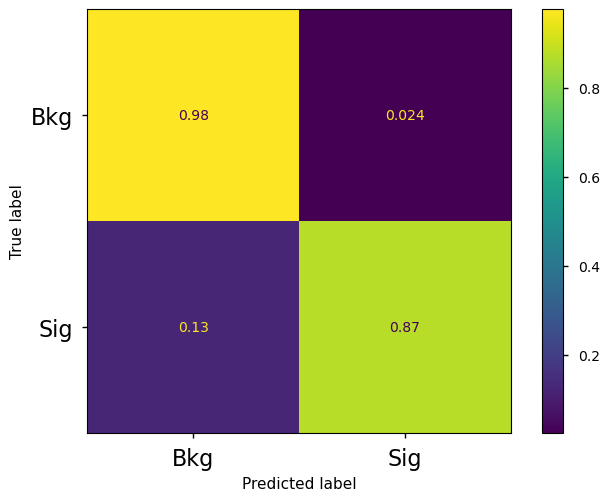

<Figure size 800x550 with 0 Axes>

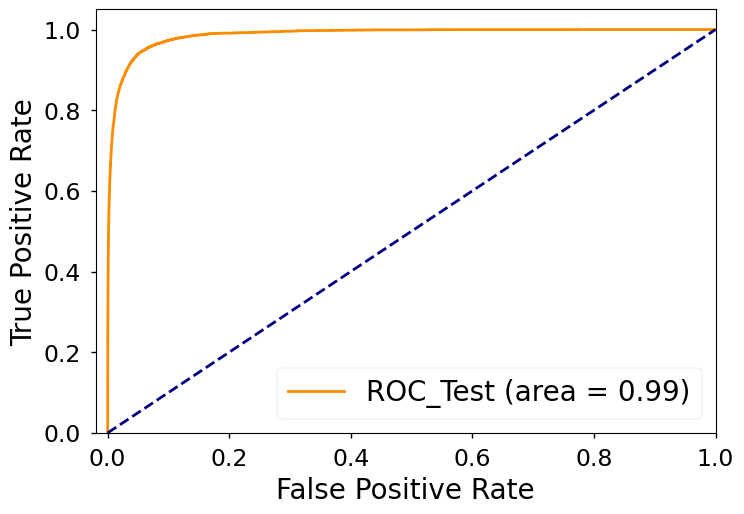

x_test of sig and comb: 75.0 - (7264, 40), (276181, 40)
y_test of sig and comb: 75.0 - (7264, 2), (276181, 2)
after shuffle: (276181, 40), (276181, 2)
x_test: [[ 0.8549096   0.06130106 -0.42474076 -0.96874802 -0.25887845 -0.52452627
  -0.67495113  0.70714426 -0.7499795   0.76426289  1.14721126 -1.15670396
  -0.80684256  0.43022264  0.2090597  -0.4936271  -1.62970474  1.90416113
  -1.01174207 -1.20125932  0.08430989 -0.12916592 -1.20519146 -0.16669612
   0.79030215  0.06786083  1.47889042  1.19745697  0.81792034 -0.58509883
  -0.15509116 -1.57831045 -0.40538986 -0.42531868 -0.2589384   0.02099242
  -0.30907325 -0.33642702 -0.2488297  -0.44200479]
 [ 0.78618068  1.58507805  1.82808582  1.70494567  3.83861144  1.02079345
  -0.988      -0.51529724  0.20872907  1.21898366 -1.38239827  1.54598469
   1.0705736  -0.52112154  1.30200539  2.71881196  0.49185073 -0.46635008
   1.48019678  0.67570328 -0.20538486 -1.17613079  0.28169811  1.13670044
   0.71597986 -1.50980665  0.57381681 -0.70282987 

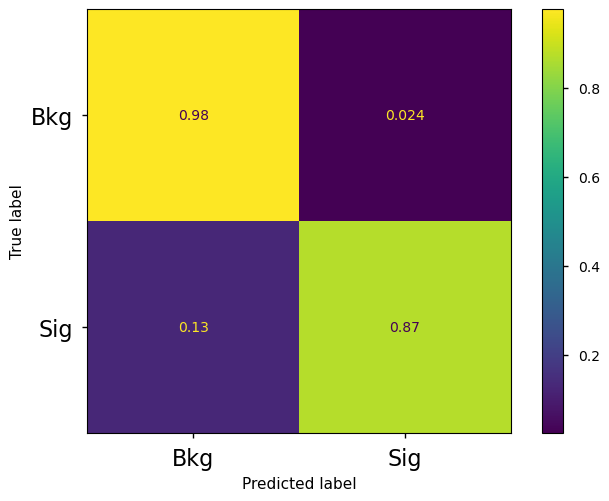

<Figure size 800x550 with 0 Axes>

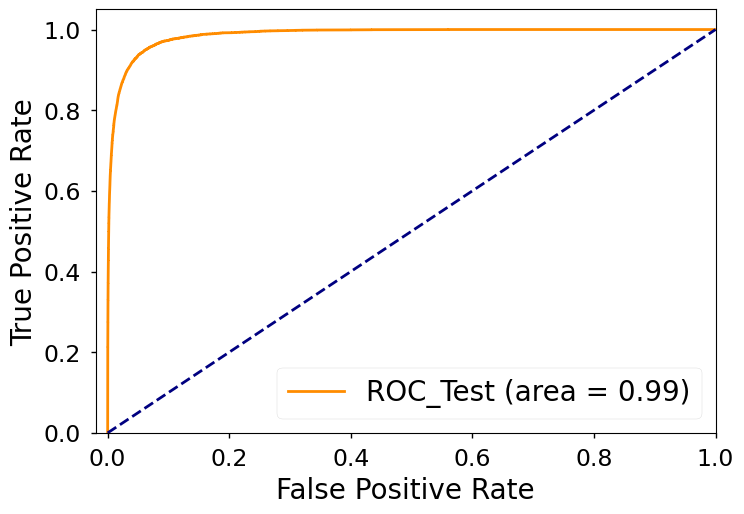

x_test of sig and comb: 88.0 - (7497, 40), (276414, 40)
y_test of sig and comb: 88.0 - (7497, 2), (276414, 2)
after shuffle: (276414, 40), (276414, 2)
x_test: [[-0.86712844 -0.88460734  2.53699135  0.83141754 -0.43634526 -0.445548
  -0.12392267 -0.86192694 -0.69836663 -0.76921905  0.85881561  0.18981761
  -0.62008114  0.28321355 -0.70384555 -0.7986542  -0.11828049 -0.82145124
  -0.60200905  0.19566361 -0.74281823  1.15379595  1.9058434   0.18236656
   0.54284035  1.158655   -0.76683011  0.36659205 -0.38829014  1.34662819
   0.53256457  1.36607105  0.58390446  1.38496999  0.97354531 -0.9440716
  -0.86110004 -0.33642702 -0.81758382  1.68259949]
 [-0.81196817 -0.77244156  2.00939059  0.57421478 -1.11583602 -0.26619163
  -0.3791621  -0.97847807  1.00914727  1.97885714  1.78905186 -1.3387331
  -0.80434595  2.11597004 -1.02354913 -0.13561526  1.31855104 -0.3564281
  -0.43816084  1.11762042  0.22369031  3.01507844  0.66120427 -0.86772584
  -0.07170728 -1.8725217  -1.21710398 -0.9219411  -0.65

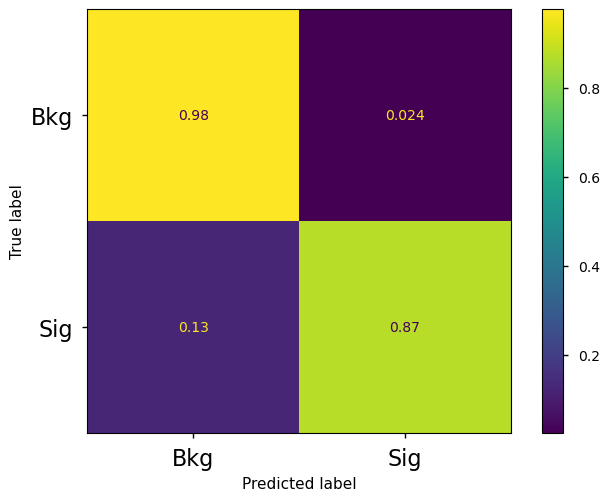

<Figure size 800x550 with 0 Axes>

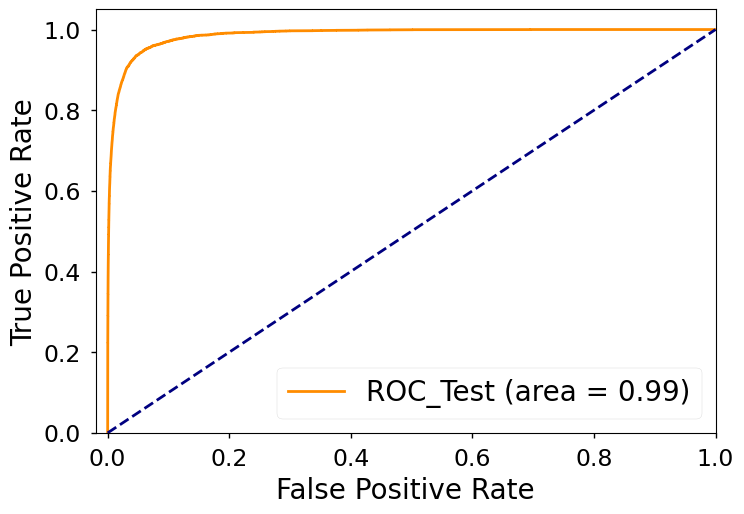

x_test of sig and comb: 100.0 - (8853, 40), (277770, 40)
y_test of sig and comb: 100.0 - (8853, 2), (277770, 2)
after shuffle: (277770, 40), (277770, 2)
x_test: [[ 0.28693265  0.30280387  0.42339343  0.0630516  -0.18433829 -0.57457865
   1.61770628  0.45317206  0.88722773 -0.02361899 -1.34378167  0.61784134
   0.08085467 -0.81193467  0.38399411  0.24161015 -0.26709739  0.27836571
  -0.1601303  -0.22123171  0.22563191  0.7621975  -0.92610519 -1.35106544
   1.0946123   0.83574034 -0.25799316  0.0605982  -0.42479145  0.54916063
  -1.10629224 -1.75588437 -1.07100574  1.19500791 -1.08483156 -0.15111845
  -0.86110004 -0.33642702 -0.81758382  0.7463332 ]
 [ 0.25085159 -0.17151281  1.91076849  0.10428589 -0.08313084 -0.7865803
   0.93166292  2.11911995 -0.96295011  0.4508021  -0.06516103  1.76887334
   0.5045051  -1.0803189   1.12959313  1.11729896  1.01100301 -0.23273549
  -0.40373531  1.73051487  0.28218644  1.85814662 -0.9136362  -1.11293758
  -0.02259593  0.17448308 -0.77665797  1.31370849

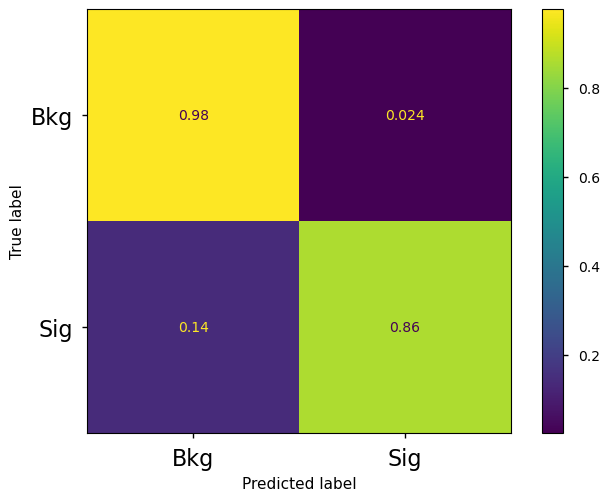

<Figure size 800x550 with 0 Axes>

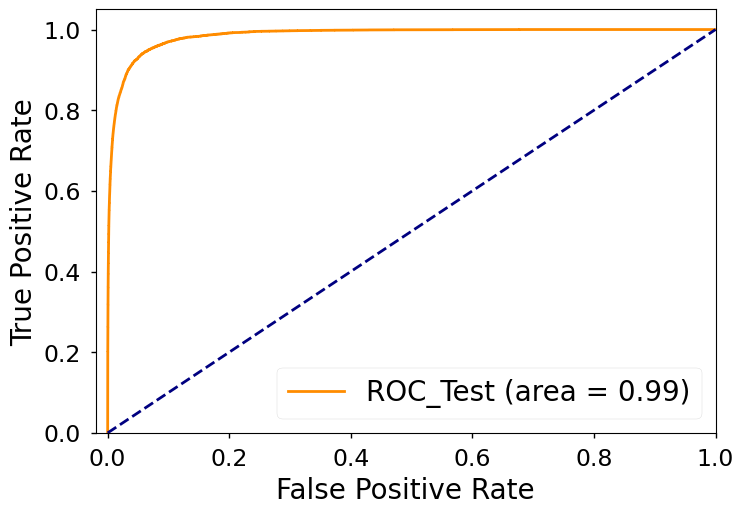

x_test of sig and comb: 121.0 - (10170, 40), (279087, 40)
y_test of sig and comb: 121.0 - (10170, 2), (279087, 2)
after shuffle: (279087, 40), (279087, 2)
x_test: [[ 0.30603995  0.14459962 -1.08334965 -1.26345394 -0.60718133  0.08746274
  -0.00853361 -0.36222778  0.78591964 -0.91609552  1.66051227  0.35697097
  -0.57342209 -0.10634843 -0.52907574 -0.82148539  0.82353343 -0.4022065
  -0.79164883  1.29644312 -0.01505582 -0.68212347  0.15466903 -1.82695106
   1.286211   -0.24867295 -0.23715618 -1.31203278  1.13686367 -1.18578572
  -2.36203582 -1.21696409 -1.57675416 -1.01321085 -0.51258081 -0.30405027
   0.79498032 -0.33642702  0.88867853 -0.91013793]
 [-0.16508092  0.36117886 -0.16186181  0.55663982 -0.18243787 -0.75552181
   1.93920504 -0.30405455 -0.37928061 -0.66141702  1.01069325  0.45746124
  -0.70097464  0.47993775 -0.56782754 -0.8231847  -0.72648471  0.3995998
   0.06382879 -0.99057669  0.04282659  0.64704381 -0.16185648  1.28428812
  -0.67080609 -0.83525914 -1.35225616 -0.0717845

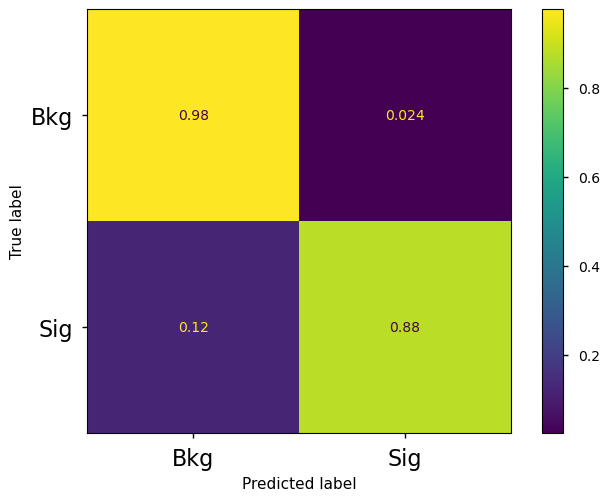

<Figure size 800x550 with 0 Axes>

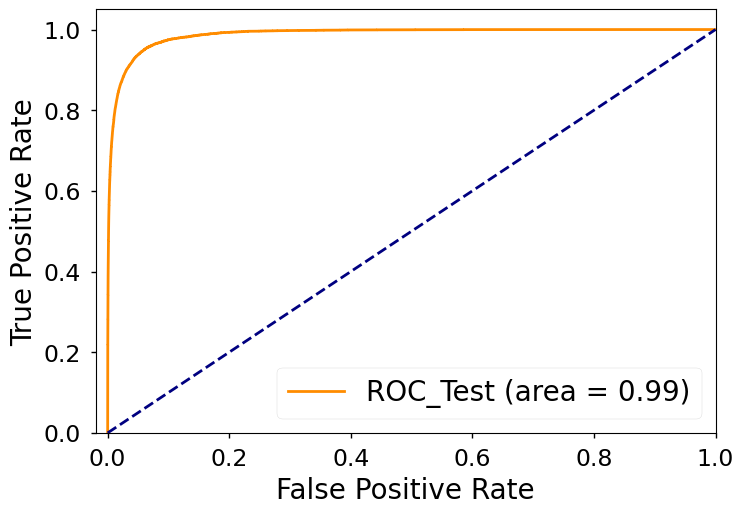

x_test of sig and comb: 147.0 - (11166, 40), (280083, 40)
y_test of sig and comb: 147.0 - (11166, 2), (280083, 2)
after shuffle: (280083, 40), (280083, 2)
x_test: [[ 1.15188113e+00  1.19146345e+00 -2.76659354e-01  6.66205760e-01
  -4.85981735e-01 -2.63416092e-01  3.24057955e-01 -8.03026111e-01
  -9.79296636e-01  2.08425479e-01  1.07602801e+00 -8.48169287e-01
  -4.01675762e-01  8.83777894e-01 -1.28707809e+00 -1.73139214e-01
   1.44603744e+00 -9.46942738e-02  1.01144369e+00  8.72759047e-01
   6.70460120e-01 -6.46500780e-01  1.78700757e-02  1.42206510e+00
  -1.86489294e+00  3.51884642e-01 -6.41654581e-01  8.34402719e-01
  -1.78166427e+00 -7.84317892e-01  7.73939102e-01  7.72382821e-01
   8.82272211e-01  3.25861138e+00 -2.21705878e-01  1.32640199e+00
  -1.41312683e+00 -3.36427023e-01 -1.38633794e+00 -1.23423011e+00]
 [ 5.68586128e-02 -3.44104500e-01 -1.05000756e+00  1.22726776e+00
  -5.79631195e-04 -6.92948709e-01 -2.68441821e-01  2.58998455e-01
  -1.09996063e-01 -3.18068912e-01  1.0641856

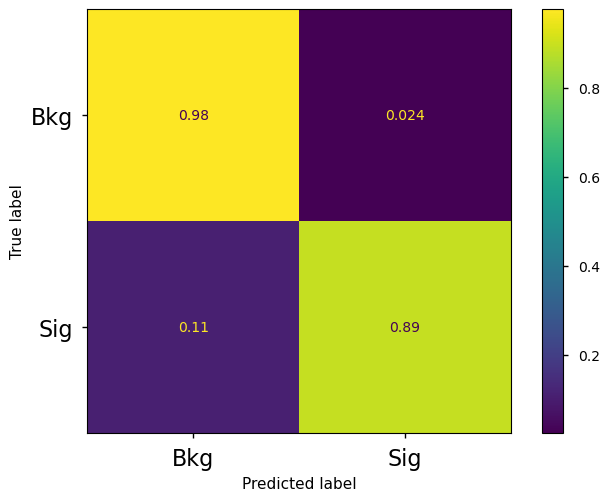

<Figure size 800x550 with 0 Axes>

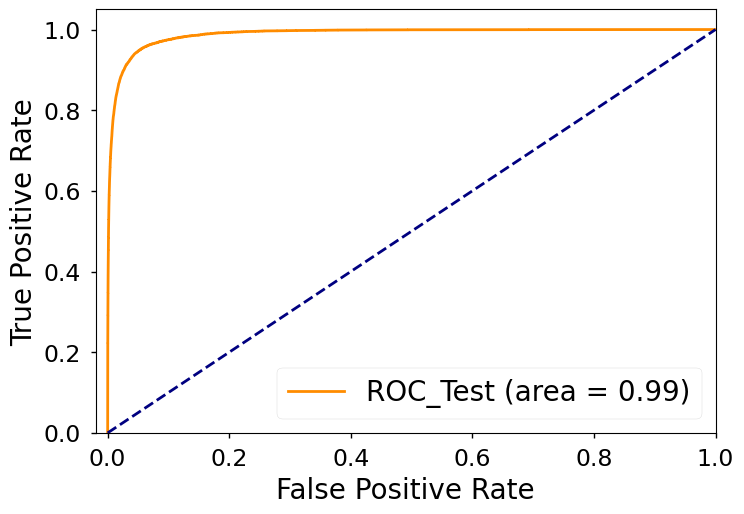

In [7]:
y_test_bkg_idxs = np.where(y_test_ == 0)[0]
y_test_sig_idxs = np.where(y_test_ == 1)[0] # np.flatnonzero(y_test_)
print(f'sig and bkg from y_test: {y_test_sig_idxs.size}, {y_test_bkg_idxs.size}, {y_test_sig_idxs}, {y_test_bkg_idxs}')
x_test_all_signals     = np.take(x_test, y_test_sig_idxs, axis=0)
y_test_all_signals     = np.take(y_test, y_test_sig_idxs, axis=0)
x_test_all_backgrounds = np.take(x_test, y_test_bkg_idxs, axis=0)
y_test_all_backgrounds = np.take(y_test, y_test_bkg_idxs, axis=0)
print(f'x_test_all_signals: {x_test_all_signals.shape}, {x_test_all_signals[:3,:]}')
print(f'y_test_all_signals: {y_test_all_signals.shape}, {y_test_all_signals[:3,:]}')
print(f'x_test_all_backgrounds: {x_test_all_backgrounds.shape}, {x_test_all_backgrounds[:3,:]}')
print(f'y_test_all_backgrounds: {y_test_all_backgrounds.shape}, {y_test_all_backgrounds[:3,:]}')

x_test_signal_list = []
for j,mass in enumerate(masspoints):
    x_test_sig_temp  = x_test_all_signals[x_test_all_signals[:,-1] == mass]
    x_test_comb_temp = np.concatenate((x_test_sig_temp, x_test_all_backgrounds), axis=0)
    y_test_sig_temp_ = np.ones(x_test_sig_temp.shape[0], dtype=int)
    y_test_sig_temp  = to_categorical(y_test_sig_temp_)
    y_test_comb_temp = np.concatenate((y_test_sig_temp, y_test_all_backgrounds), axis=0)
    print(f'x_test of sig and comb: {raw_mass[j]} - {x_test_sig_temp.shape}, {x_test_comb_temp.shape}')
    print(f'y_test of sig and comb: {raw_mass[j]} - {y_test_sig_temp.shape}, {y_test_comb_temp.shape}')    
    shuffle_idxs = np.random.permutation(x_test_comb_temp.shape[0])
    x_test_pNN = x_test_comb_temp[shuffle_idxs]
    y_test_pNN = y_test_comb_temp[shuffle_idxs]
    print(f'after shuffle: {x_test_pNN.shape}, {y_test_pNN.shape}')
    print(f'x_test: {x_test_pNN[:2,:]}')
    print(f'y_test: {y_test_pNN[:2,:]}')
    
    score_test    = model.predict(x_test_pNN)
    y_predProbaNoCutOnProb = score_test[:,-1]
    y_predClassNoCutOnProb = np.asarray([np.argmax(item) for item in score_test])
    y_true                 = y_test_pNN[:,-1].astype(int)
    
    cnf_matrix = confusion_matrix(y_true, y_predClassNoCutOnProb, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
    disp.plot()
    plt.grid(False)
    plt.xticks(ticks=[1,0], labels=['Sig','Bkg'], fontsize=16)
    plt.yticks(ticks=[1,0], labels=['Sig','Bkg'], fontsize=16)
    plt.savefig(os.path.join(tagdir,f'conf_matrix_{int(raw_mass[j])}.png'), dpi=300)
    #plt.savefig(os.path.join(tagdir,'conf_matrix.pdf'), dpi=300)
    plt.show()
    plt.clf()
    
    fpr, tpr, _ = roc_curve(y_true, y_predProbaNoCutOnProb)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC_Test (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.xlabel('False Positive Rate',size=20)
    plt.ylabel('True Positive Rate',size=20)
    plt.legend(loc="lower right", fontsize=20)
    plt.savefig(os.path.join(tagdir,f'ROC_{int(raw_mass[j])}.png'), dpi=300)
    #plt.savefig(os.path.join(tagdir,'ROC.pdf'), dpi=300)
    plt.show()

# Evaluation: Keep the responses in csv files

In [8]:
'''
x_comb  = combined_set[:,:-1]
y_comb_ = combined_set[:,-1]
y_comb  = to_categorical(y_comb_)
print(x_comb.shape, x_comb)
print(y_comb.shape, y_comb)

score      = model.predict(x_comb)
y_predProb = score[:,-1]

#df_combined_all_events['score'] = y_predProb

#print(df_combined_all_events.keys())
print(y_predProb)
complete_result = np.concatenate((combined_set, y_predProb), axis=1)
df_complete_result = pd.DataFrame(complete_result, columns = list(train_featuredict.keys())+['mass','tag','score'])
print(df_complete_result)
'''

"\nx_comb  = combined_set[:,:-1]\ny_comb_ = combined_set[:,-1]\ny_comb  = to_categorical(y_comb_)\nprint(x_comb.shape, x_comb)\nprint(y_comb.shape, y_comb)\n\nscore      = model.predict(x_comb)\ny_predProb = score[:,-1]\n\n#df_combined_all_events['score'] = y_predProb\n\n#print(df_combined_all_events.keys())\nprint(y_predProb)\ncomplete_result = np.concatenate((combined_set, y_predProb), axis=1)\ndf_complete_result = pd.DataFrame(complete_result, columns = list(train_featuredict.keys())+['mass','tag','score'])\nprint(df_complete_result)\n"

# Test

In [9]:
'''
raw = np.asarray([1])
raw_cat = to_categorical(raw, 2)
print(f'{raw} to_categorical --> {raw_cat}')

score_train   = model.predict(x_train)
score_test    = model.predict(x_test)
print(f'prediction probabilities for test dataset :\n {score_test}')
y_predProbaNoCutOnProb = score_test[:,-1]
y_predClassNoCutOnProb = np.asarray([np.argmax(item) for item in score_test])
y_true                 = y_test[:,-1].astype(int)
y_predProbaNoCutOnProbTrain = score_train[:,-1]
y_predClassNoCutOnProbTrain = np.asarray([np.argmax(item) for item in score_train])
y_trueTrain                 = y_train[:,-1].astype(int)
print(f'y_test : \n {y_test}')
print(f'y_predication :\n {y_predClassNoCutOnProb}')
print(f'y_true :\n {y_true}')
cnf_matrix = confusion_matrix(y_true, y_predClassNoCutOnProb, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.xticks(ticks=[1,0], labels=['Sig','Bkg'], fontsize=16)
plt.yticks(ticks=[1,0], labels=['Sig','Bkg'], fontsize=16)
plt.savefig(os.path.join(tagdir,'conf_matrix.png'), dpi=300)
plt.savefig(os.path.join(tagdir,'conf_matrix.pdf'), dpi=300)
plt.show()
plt.clf()

fpr_t, tpr_t, _ = roc_curve(y_trueTrain, y_predProbaNoCutOnProbTrain)
fpr, tpr, _ = roc_curve(y_true, y_predProbaNoCutOnProb)
roc_auc_t = auc(fpr_t, tpr_t)
roc_auc = auc(fpr, tpr)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC_Test (area = %0.2f)' % roc_auc)
plt.plot(fpr_t, tpr_t, color='green',
         lw=lw, label='ROC_Train (area = %0.2f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)
#plt.title('ROC curve')
plt.legend(loc="lower right", fontsize=20)
plt.savefig(os.path.join(tagdir,'ROC.png'), dpi=300)
plt.savefig(os.path.join(tagdir,'ROC.pdf'), dpi=300)
plt.show()


import csv
fpr_tpr_to_write = list(zip(fpr, tpr))
with open(os.path.join(tagdir,f'ROC_Info_{channel}.csv'), 'w') as csvf:
    writer = csv.writer(csvf)
    writer.writerows(fpr_tpr_to_write)
'''    

'\nraw = np.asarray([1])\nraw_cat = to_categorical(raw, 2)\nprint(f\'{raw} to_categorical --> {raw_cat}\')\n\nscore_train   = model.predict(x_train)\nscore_test    = model.predict(x_test)\nprint(f\'prediction probabilities for test dataset :\n {score_test}\')\ny_predProbaNoCutOnProb = score_test[:,-1]\ny_predClassNoCutOnProb = np.asarray([np.argmax(item) for item in score_test])\ny_true                 = y_test[:,-1].astype(int)\ny_predProbaNoCutOnProbTrain = score_train[:,-1]\ny_predClassNoCutOnProbTrain = np.asarray([np.argmax(item) for item in score_train])\ny_trueTrain                 = y_train[:,-1].astype(int)\nprint(f\'y_test : \n {y_test}\')\nprint(f\'y_predication :\n {y_predClassNoCutOnProb}\')\nprint(f\'y_true :\n {y_true}\')\ncnf_matrix = confusion_matrix(y_true, y_predClassNoCutOnProb, normalize=\'true\')\ndisp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)\ndisp.plot()\nplt.grid(False)\nplt.xticks(ticks=[1,0], labels=[\'Sig\',\'Bkg\'], fontsize=16)\nplt.yticks(tick

## Test/Signal 

# Permutation importance [Features]

In [10]:
if dofeatplot:
    import math
    outputs = model.predict(x_train,batch_size=10000,verbose=0)
    targets = y_train
    true_F1_score = f1_score(targets.argmax(1),outputs.argmax(1))
    print(true_F1_score)

    f1_scores = np.zeros(len(featurelist))
    f1_scores_err = np.zeros(len(featurelist))
    permutations = 10
    pbar = enlighten.Counter(total=len(featurelist), desc='Permutations', unit='Input') 
    for idx, feat in enumerate(featurelist):
        pbar.update()
        x_train_copy = x_train.copy()
        perm_f1_scores = []
        for perm in range(permutations):
            x_train_copy[:,idx] = np.random.rand(x_train_copy.shape[0])
            #print(f'............... {x_train_copy}')
            outputs_perm = model.predict(x_train_copy,batch_size=10000)
            perm_f1_scores.append(f1_score(targets.argmax(1),outputs_perm.argmax(1)))

        perm_f1_scores = np.array(perm_f1_scores)    
        f1_scores[idx] = abs(perm_f1_scores.mean()-true_F1_score)/true_F1_score
        f1_scores_err[idx] = perm_f1_scores.std()
        #print(f' {feat} |||||| {f1_scores[idx]}, {f1_scores_err[idx]}')

    idxSort = np.flip(np.argsort(f1_scores))
    f1_scores = f1_scores[idxSort]
    inputNames = np.array(featurelist,dtype=object)[idxSort]
    f1_scores_err = f1_scores_err[idxSort]

    fig, ax = plt.subplots(figsize=(12.5,15))
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.1)
    y_pos = np.arange(len(featurelist))
    ax.barh(y_pos,f1_scores,xerr=f1_scores_err,align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(inputNames,size=int(80/math.sqrt(len(featurelist))))
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Importance',fontsize=18)
    plt.xticks(fontsize=16 )
    #name = os.path.join(self.path_out,'feature_importance.png')
    #        fig.savefig(name)
    #        logging.info("... saved as %s"%name)
    plt.savefig(os.path.join(tagdir,'FeatImportance.png'), dpi=300)
    plt.savefig(os.path.join(tagdir,'FeatImportance.pdf'), dpi=300)
    plt.show()
else:
    print('WARNING : make dofeatplot = True to plot the feature importance')

0.8771932379461413


IndexError: index 40 is out of bounds for axis 1 with size 40